In [1]:
#装载GoogleDrive云端网盘
from google.colab import drive
drive.mount('/content/drive')
#复制数据到云盘
!git clone 'https://github.com/liunaipeng/rop.git' '/content/drive/MyDrive/rop'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path '/content/drive/MyDrive/rop' already exists and is not an empty directory.


In [2]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# 使用r2_score评价模型在测试集和训练集上的性能，并输出评估结果
from sklearn.metrics import r2_score  #评价回归预测模型的性能
from sklearn.metrics import mean_squared_error#MSE
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [4]:
#读取数据
train_rop = pd.read_csv('/content/drive/MyDrive/rop/qcrop.csv')
# train_merge.loc[train_merge.ROP>20,'ROP']=None
train_rop.interpolate()
# train_merge=train_merge.drop(['Dcs','MW_out','conductivity_out','temprature_out','formation pressure gradient','FV'],axis=1)
train_rop=train_rop.fillna(method='ffill')

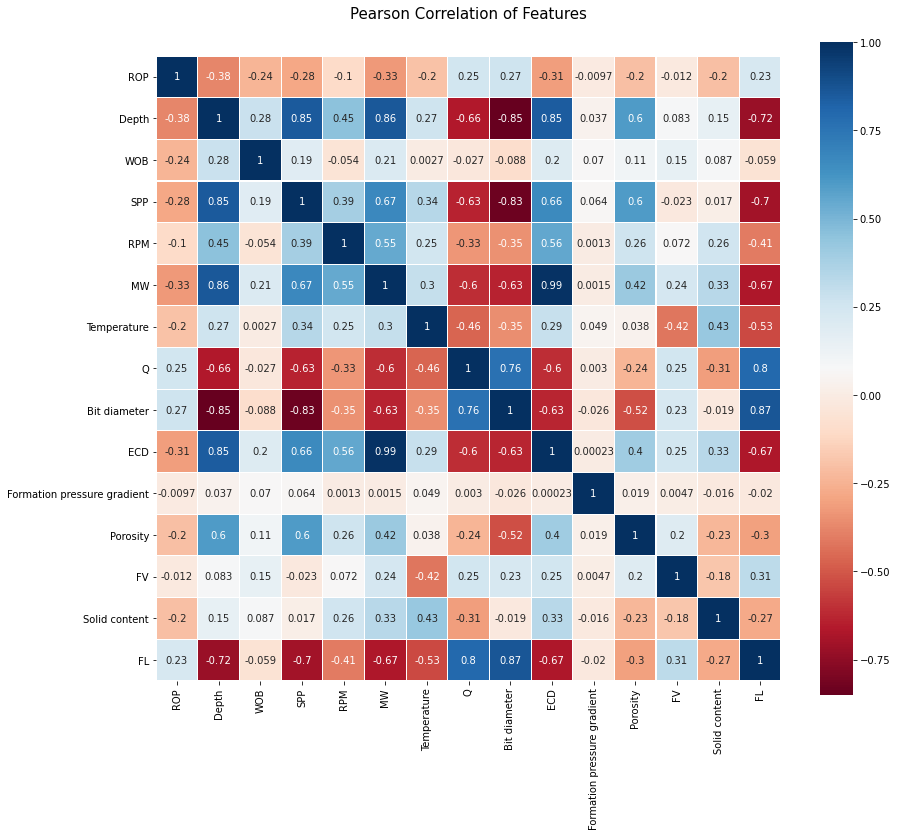

In [5]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_rop.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [6]:
train_rop=train_rop.drop(['Formation pressure gradient','FV'],axis=1)

In [7]:
train_rop.describe()

,ROP,Depth,WOB,SPP,RPM,MW,Temperature,Q,Bit diameter,ECD,Porosity,Solid content,FL
count,2383.000000,2383.000000,2383.00000,2383.000000,2383.000000,2383.000000,2383.00000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000
mean,2.868321,1200.530843,57.79572,5.293957,51.379354,1.145069,30.00042,1.981565,314.272514,1.158682,1.527000,0.245741,4.112065
std,2.617734,687.413172,32.62180,2.187228,25.028657,0.066219,2.92855,0.293285,69.423353,0.065808,0.532521,0.059597,0.982396
min,0.260000,10.000000,0.00000,0.000000,30.000000,1.020000,20.00000,0.647000,216.000000,1.000000,1.000000,0.100000,3.300000
25%,1.320000,605.500000,32.80000,4.200000,33.000000,1.100000,28.00000,1.823000,311.100000,1.110000,1.250000,0.200000,3.528571
50%,2.070000,1201.000000,48.20000,5.400000,35.000000,1.140000,30.00000,1.878000,311.100000,1.150000,1.310000,0.200000,3.700000
75%,3.490000,1796.500000,74.50000,6.300000,60.000000,1.180000,32.00000,1.943000,311.100000,1.200000,1.690000,0.300000,3.969031
max,28.300000,2389.000000,202.30000,11.500000,120.000000,1.300000,36.00000,2.807000,444.500000,1.310000,12.830000,0.400000,7.000000


In [8]:
train_2=train_rop.copy(deep=True) 
numerical_features=train_rop.columns
from scipy.signal import savgol_filter
filter_features=['ROP', 'Depth', 'WOB', 'SPP',  'MW', 'Temperature', 'Q',
        'ECD', 'Porosity' ]
for i in filter_features:
    train_2[i]=savgol_filter(train_2[i],11,3)
cols=train_2.columns
train_2_stand=train_2

min_max_scaler = MinMaxScaler()
# min_max_scaler=StandardScaler()
train_2_stand = min_max_scaler.fit_transform(train_2_stand)
train_2_stand=pd.DataFrame(columns=cols,data=train_2_stand)

y = train_2_stand['ROP']   
X = train_2_stand.drop(["ROP"], axis=1)

#将数据分割训练数据与测试数据


from sklearn.model_selection import train_test_split
# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)


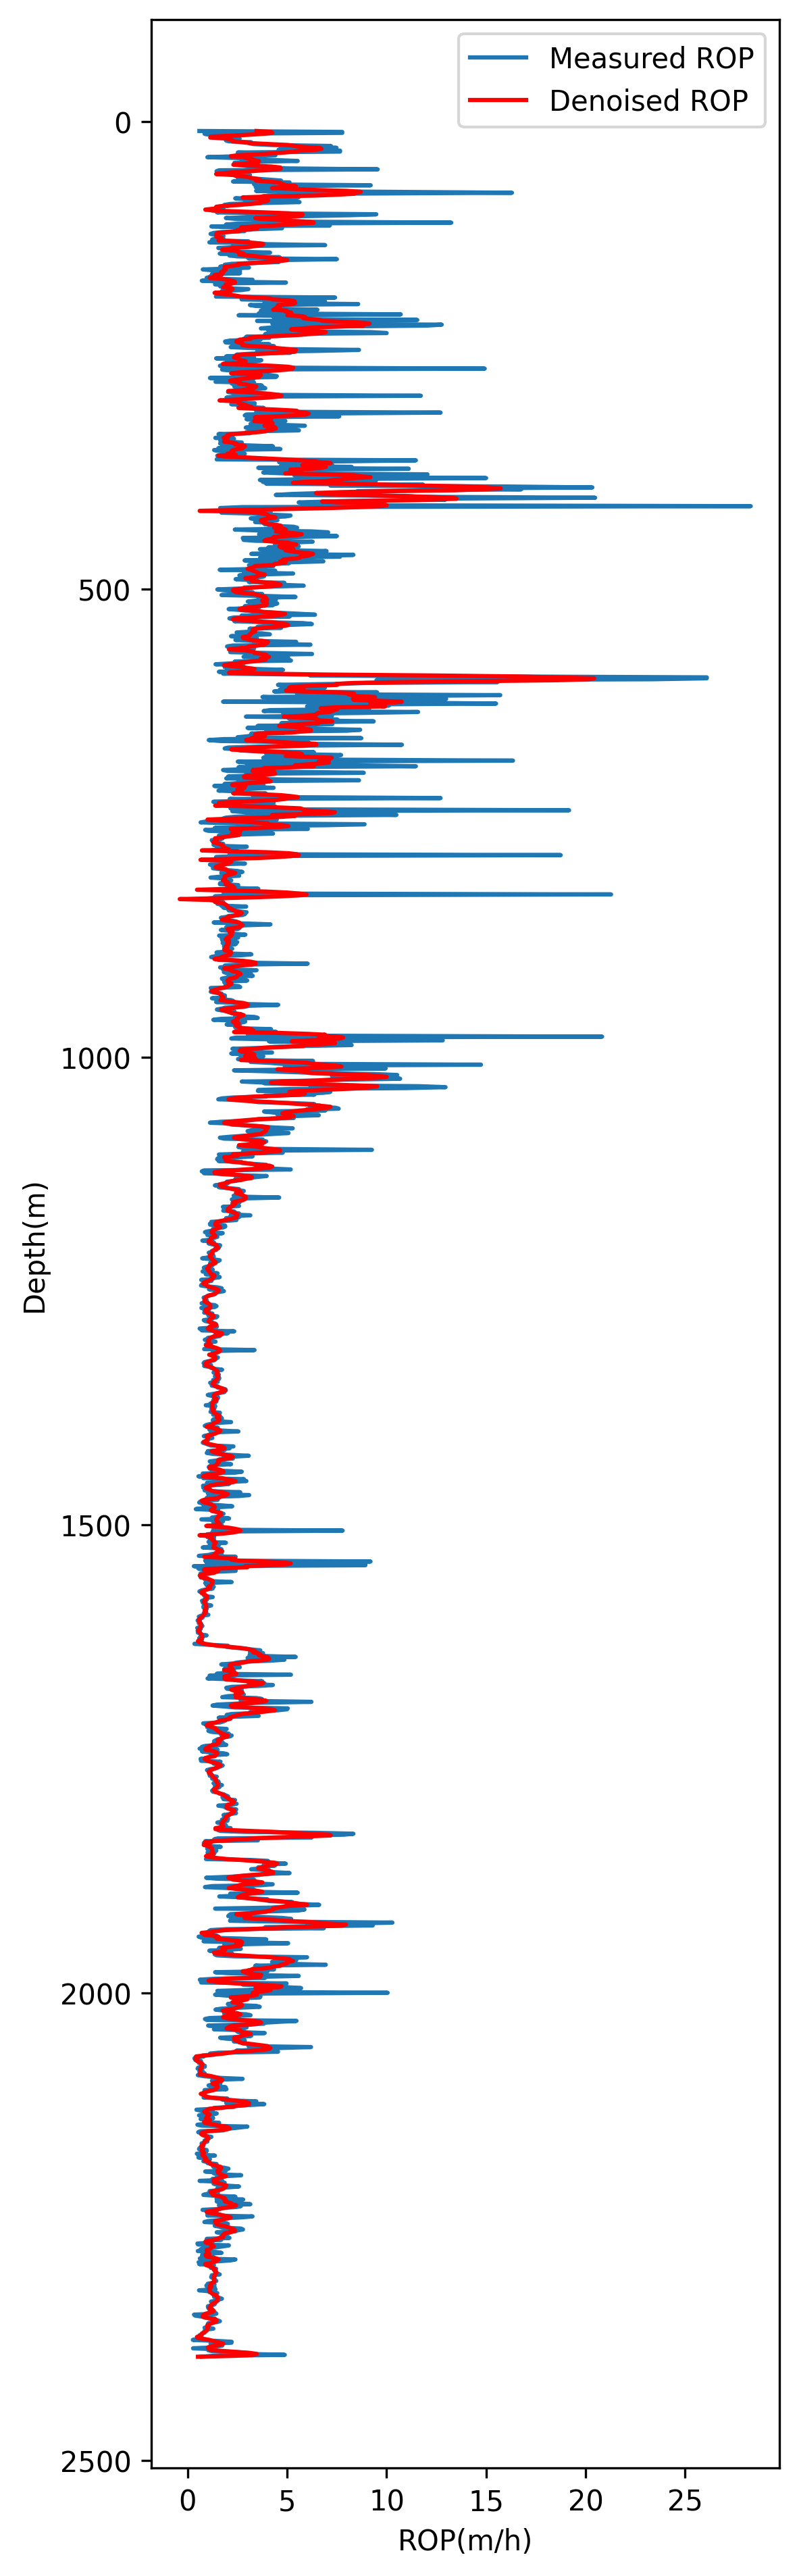

In [9]:
#对比滤波前后数据
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['ROP'],train_rop['Depth'],label='Measured ROP')
plt.plot(train_2['ROP'],train_2['Depth'],color='r',label='Denoised ROP')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('ROP(m/h)')
plt.ylabel('Depth(m)')
plt.legend()

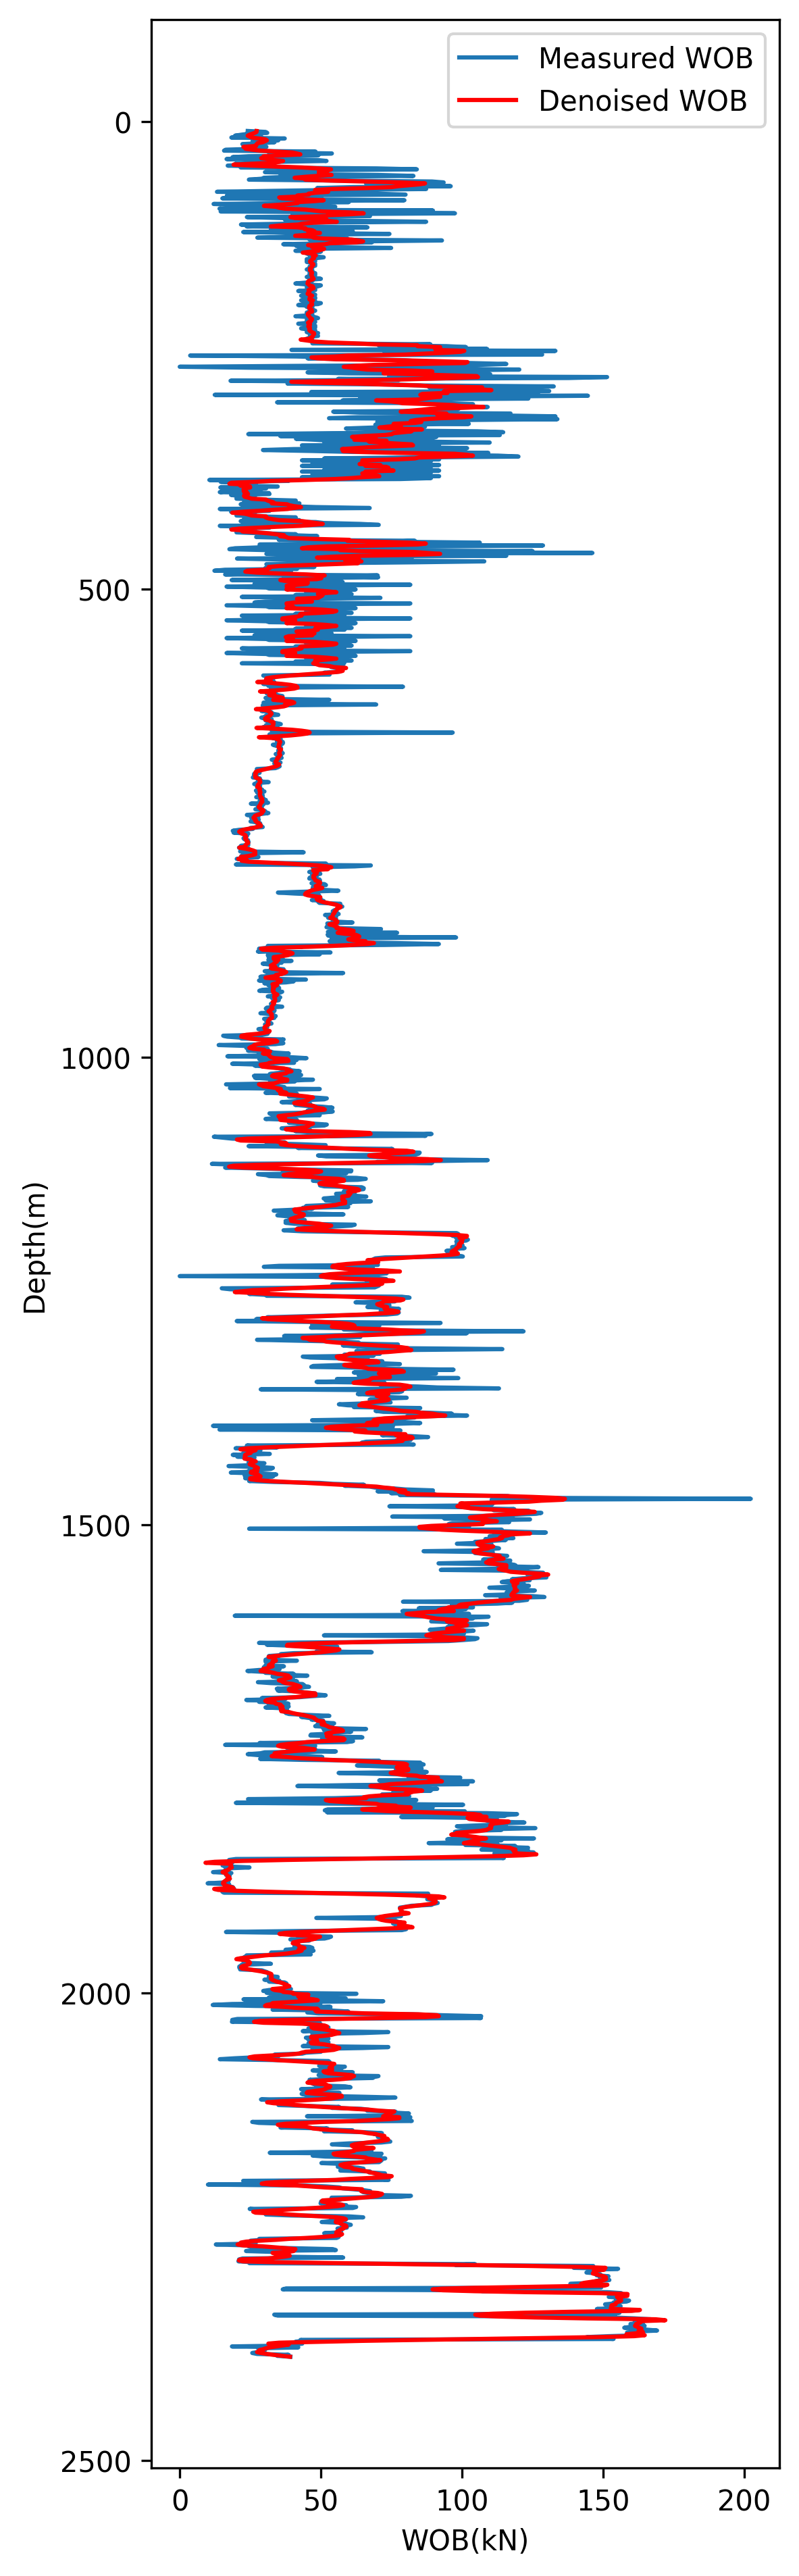

In [10]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['WOB'],train_rop['Depth'],label='Measured WOB')
plt.plot(train_2['WOB'],train_2['Depth'],color='r',label='Denoised WOB')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('WOB(kN)')
plt.ylabel('Depth(m)')
plt.legend()

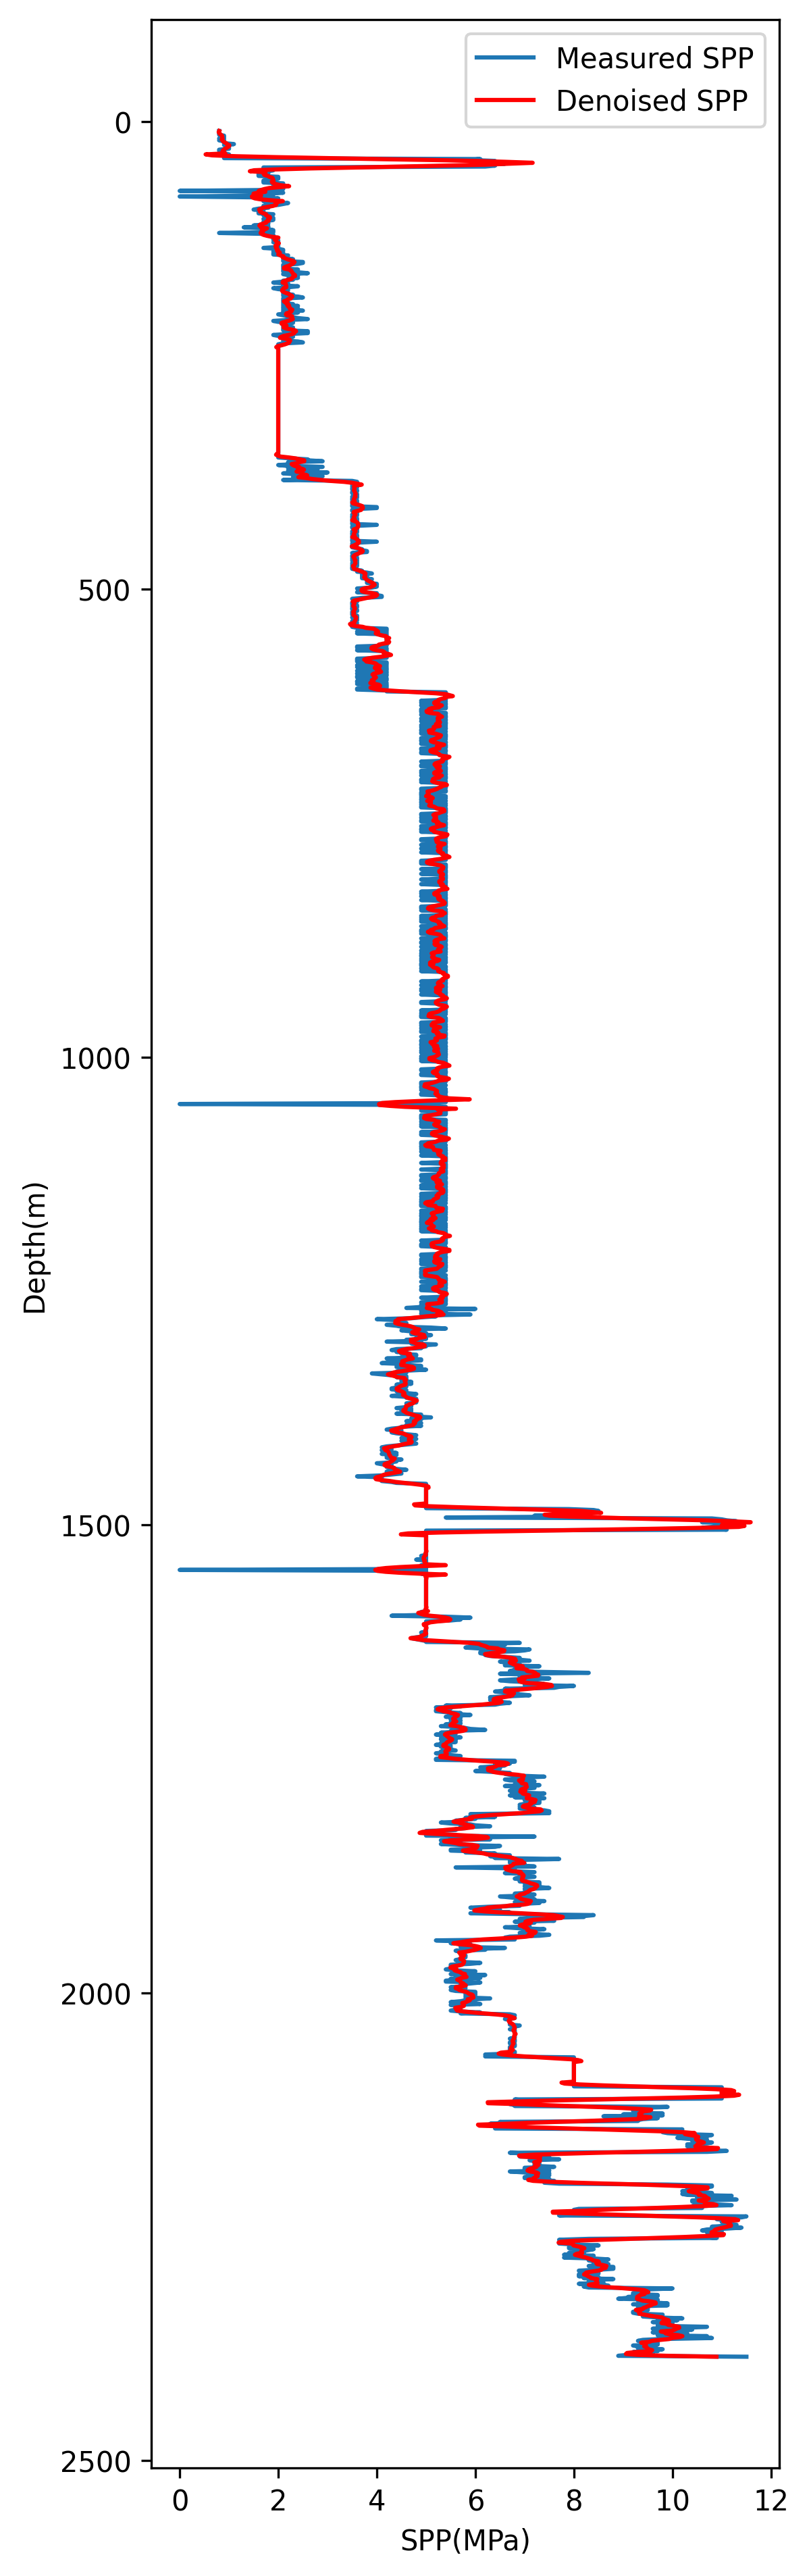

In [11]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['SPP'],train_rop['Depth'],label='Measured SPP')
plt.plot(train_2['SPP'],train_2['Depth'],color='r',label='Denoised SPP')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('SPP(MPa)')
plt.ylabel('Depth(m)')
plt.legend()

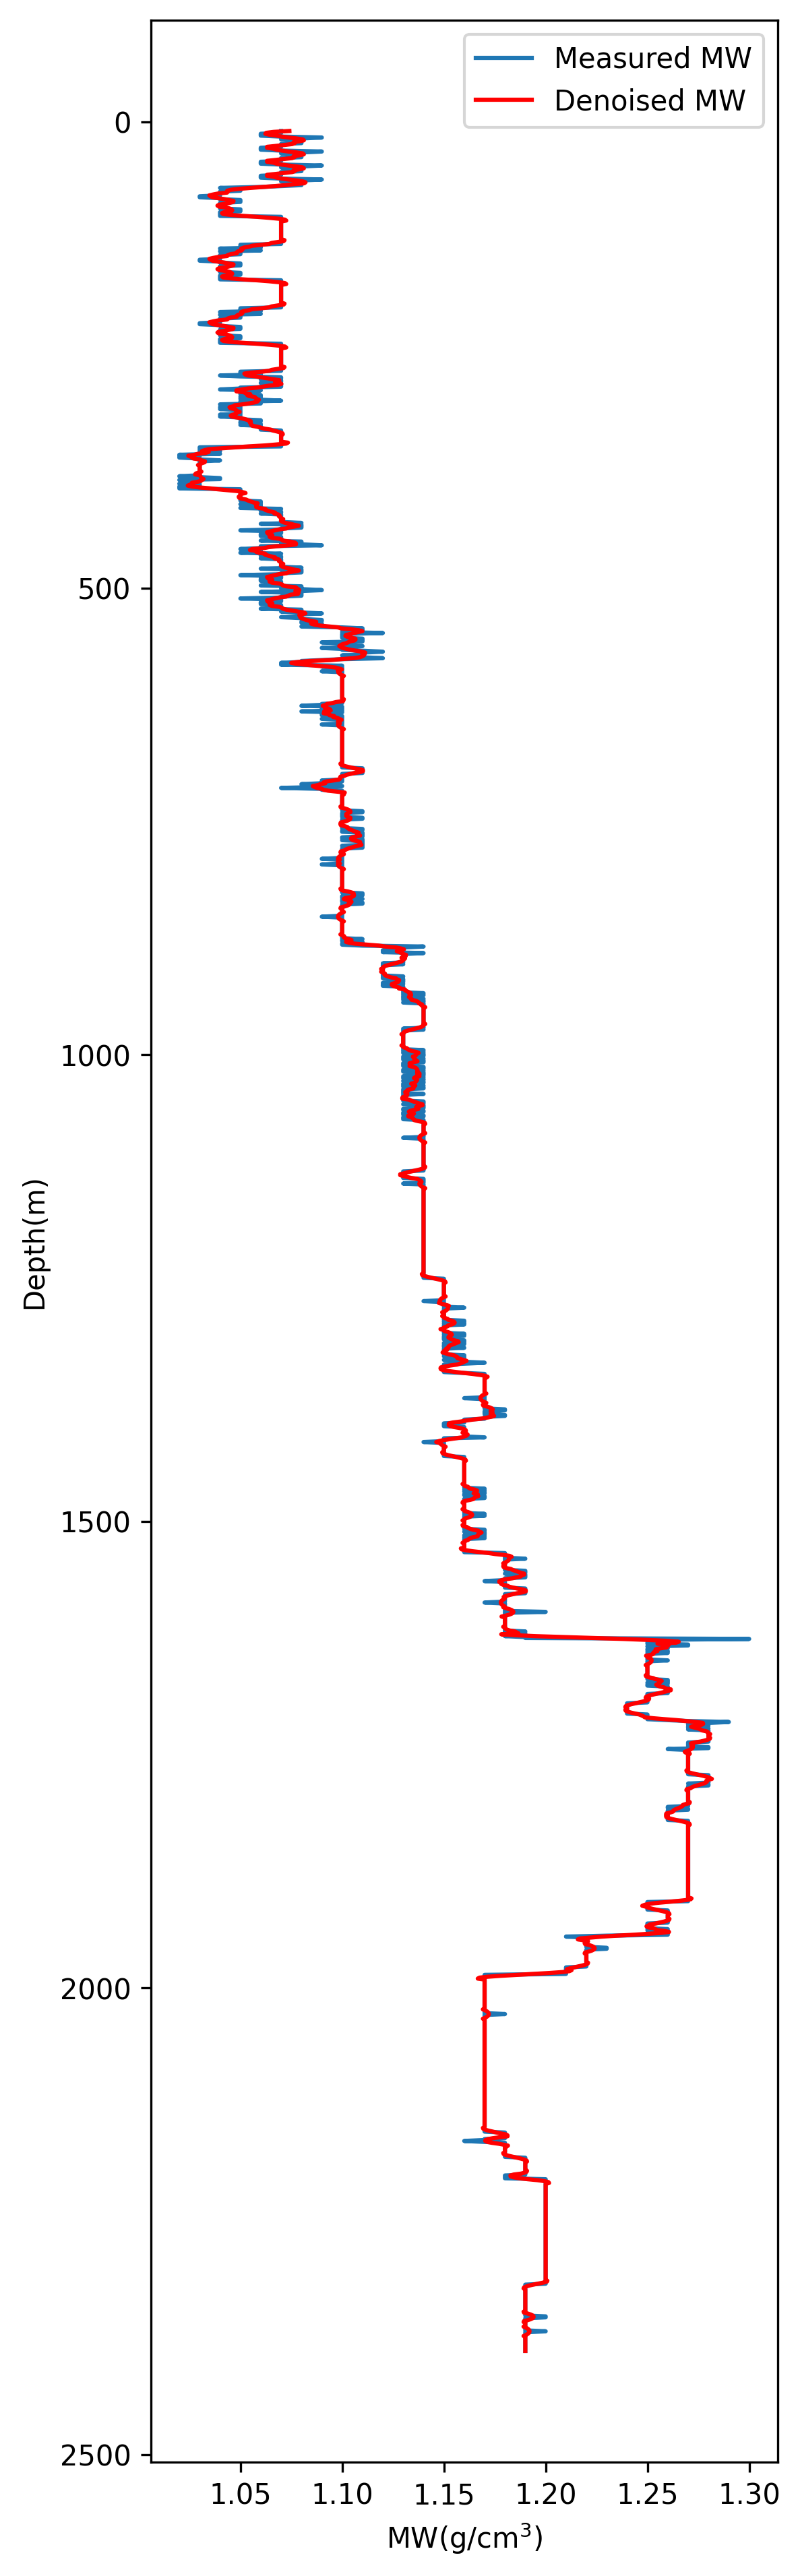

In [12]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['MW'],train_rop['Depth'],label='Measured MW')
plt.plot(train_2['MW'],train_2['Depth'],color='r',label='Denoised MW')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('MW(g/cm$^3$)')
plt.ylabel('Depth(m)')
plt.legend()

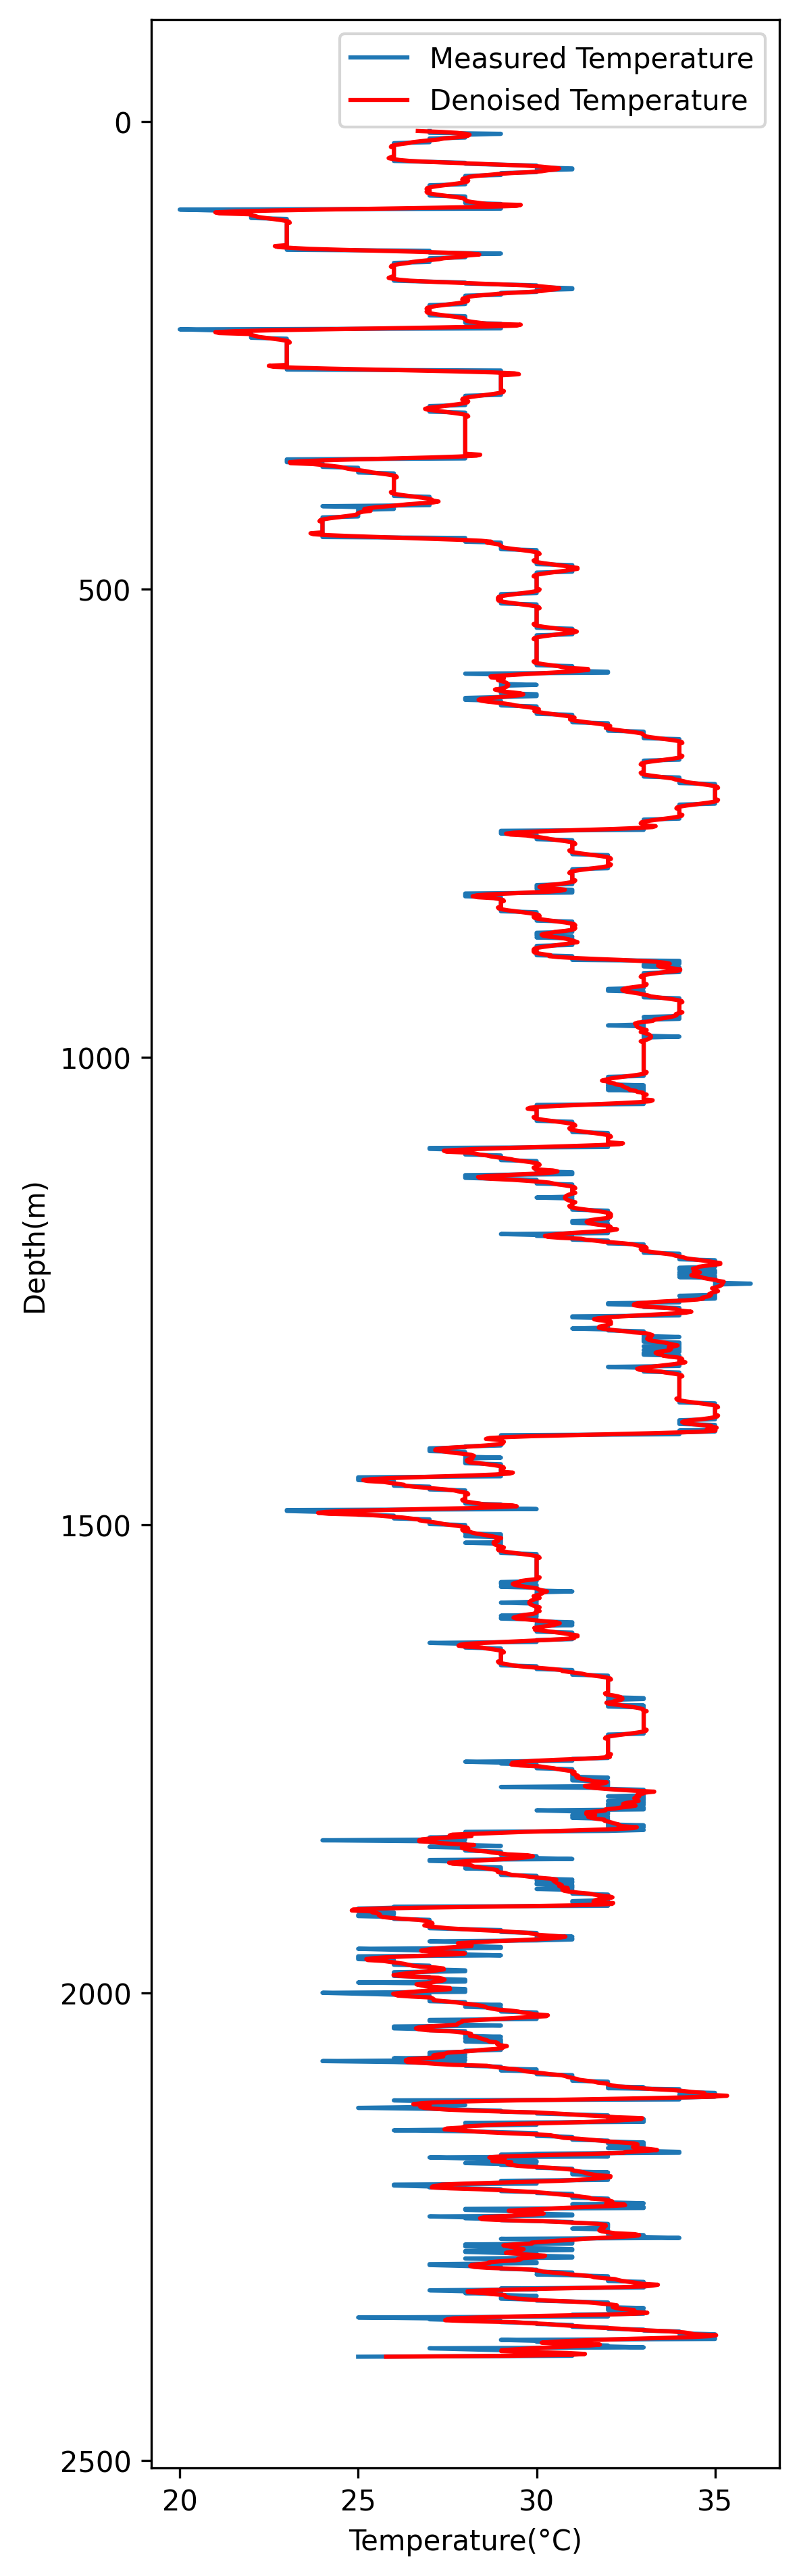

In [13]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['Temperature'],train_rop['Depth'],label='Measured Temperature')
plt.plot(train_2['Temperature'],train_2['Depth'],color='r',label='Denoised Temperature')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('Temperature(°C)')
plt.ylabel('Depth(m)')
plt.legend()

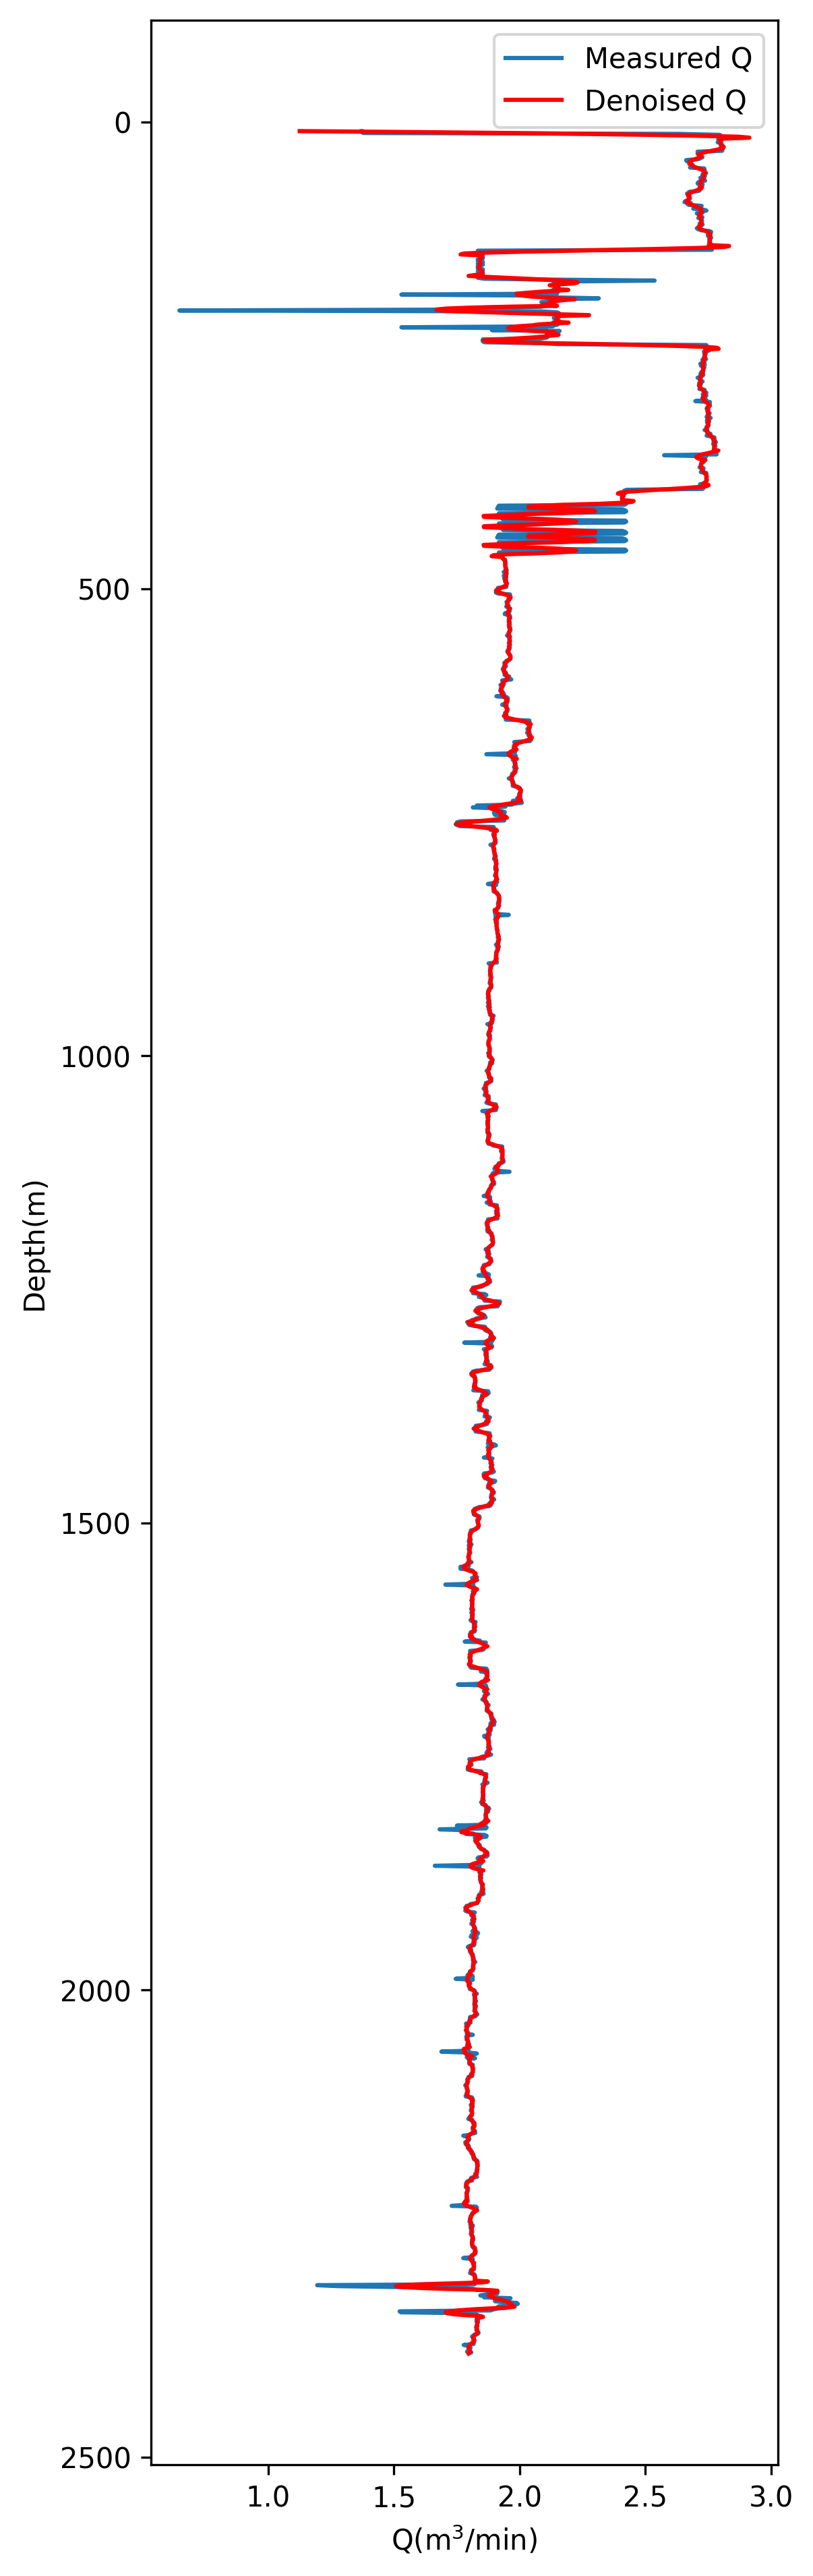

In [14]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['Q'],train_rop['Depth'],label='Measured Q')
plt.plot(train_2['Q'],train_2['Depth'],color='r',label='Denoised Q')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('Q(m$^3$/min)')
plt.ylabel('Depth(m)')
plt.legend()

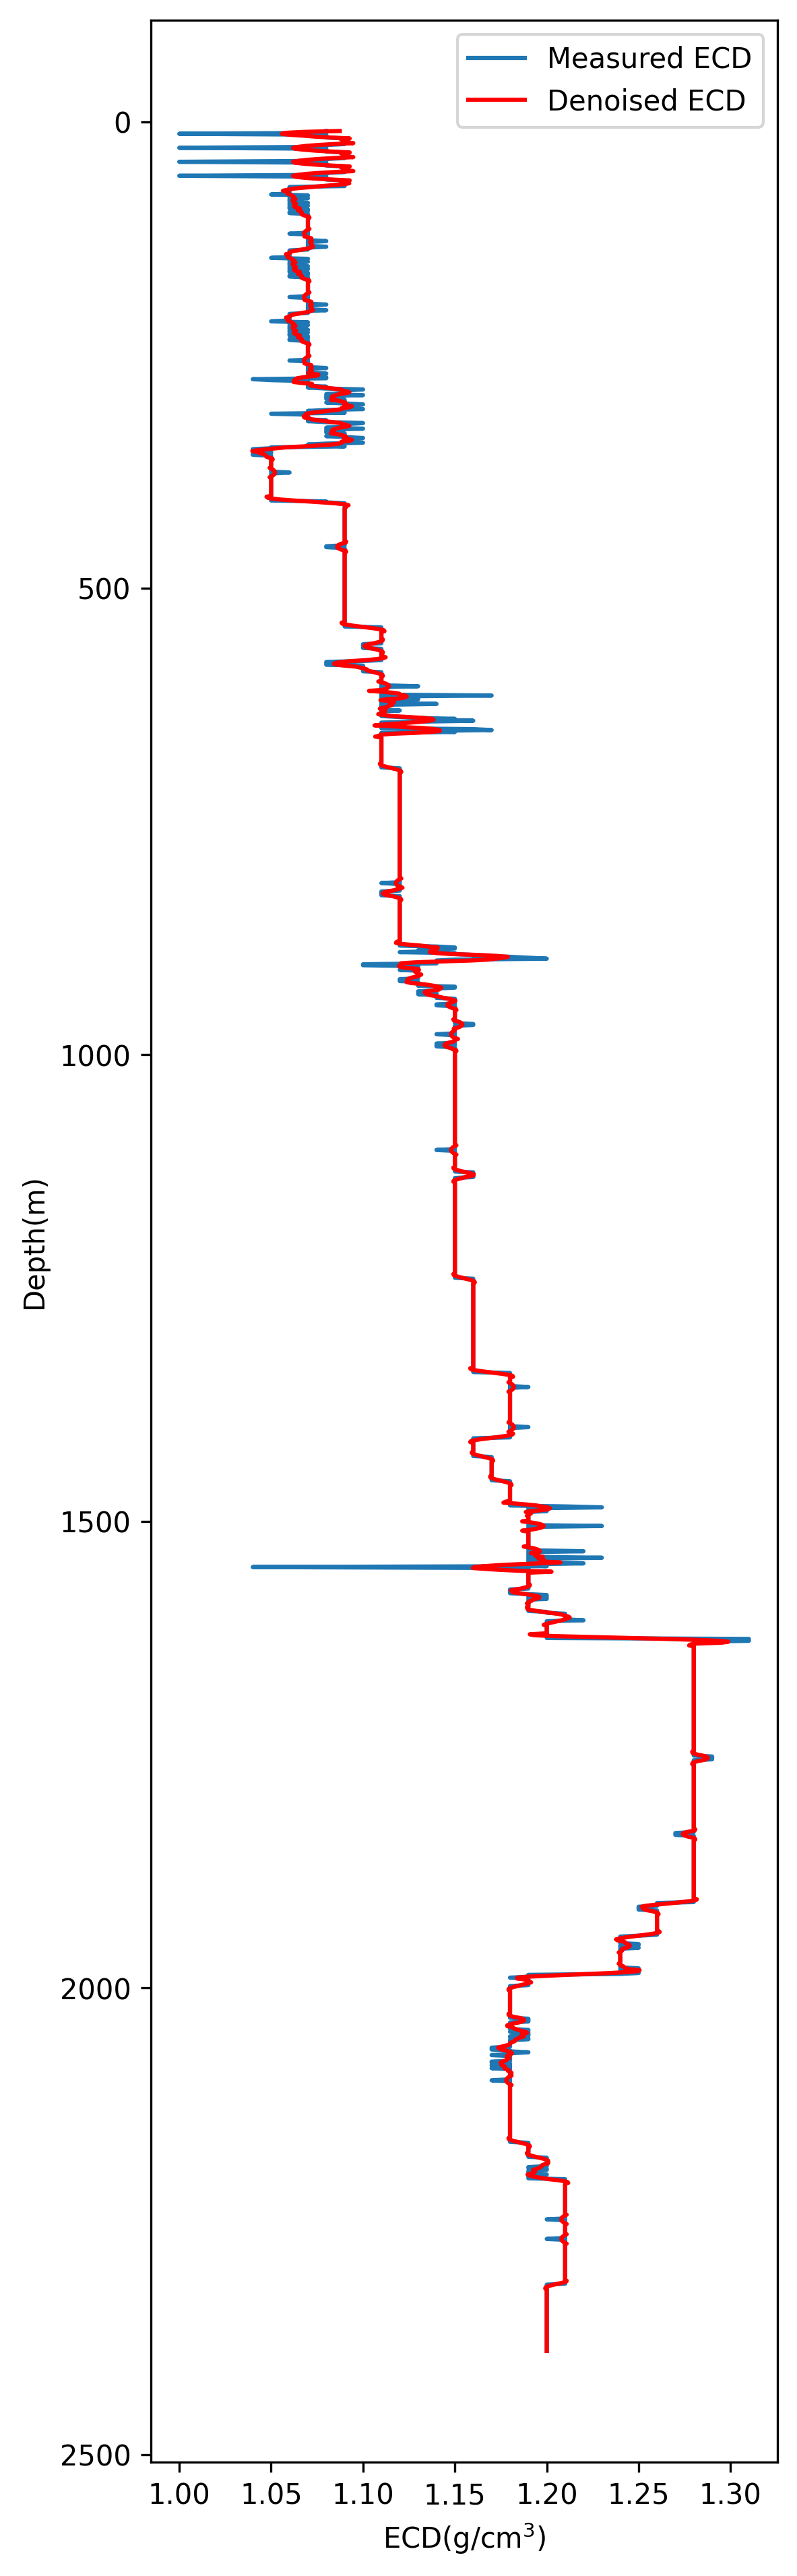

In [15]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['ECD'],train_rop['Depth'],label='Measured ECD')
plt.plot(train_2['ECD'],train_2['Depth'],color='r',label='Denoised ECD')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('ECD(g/cm$^3$)')
plt.ylabel('Depth(m)')
plt.legend()

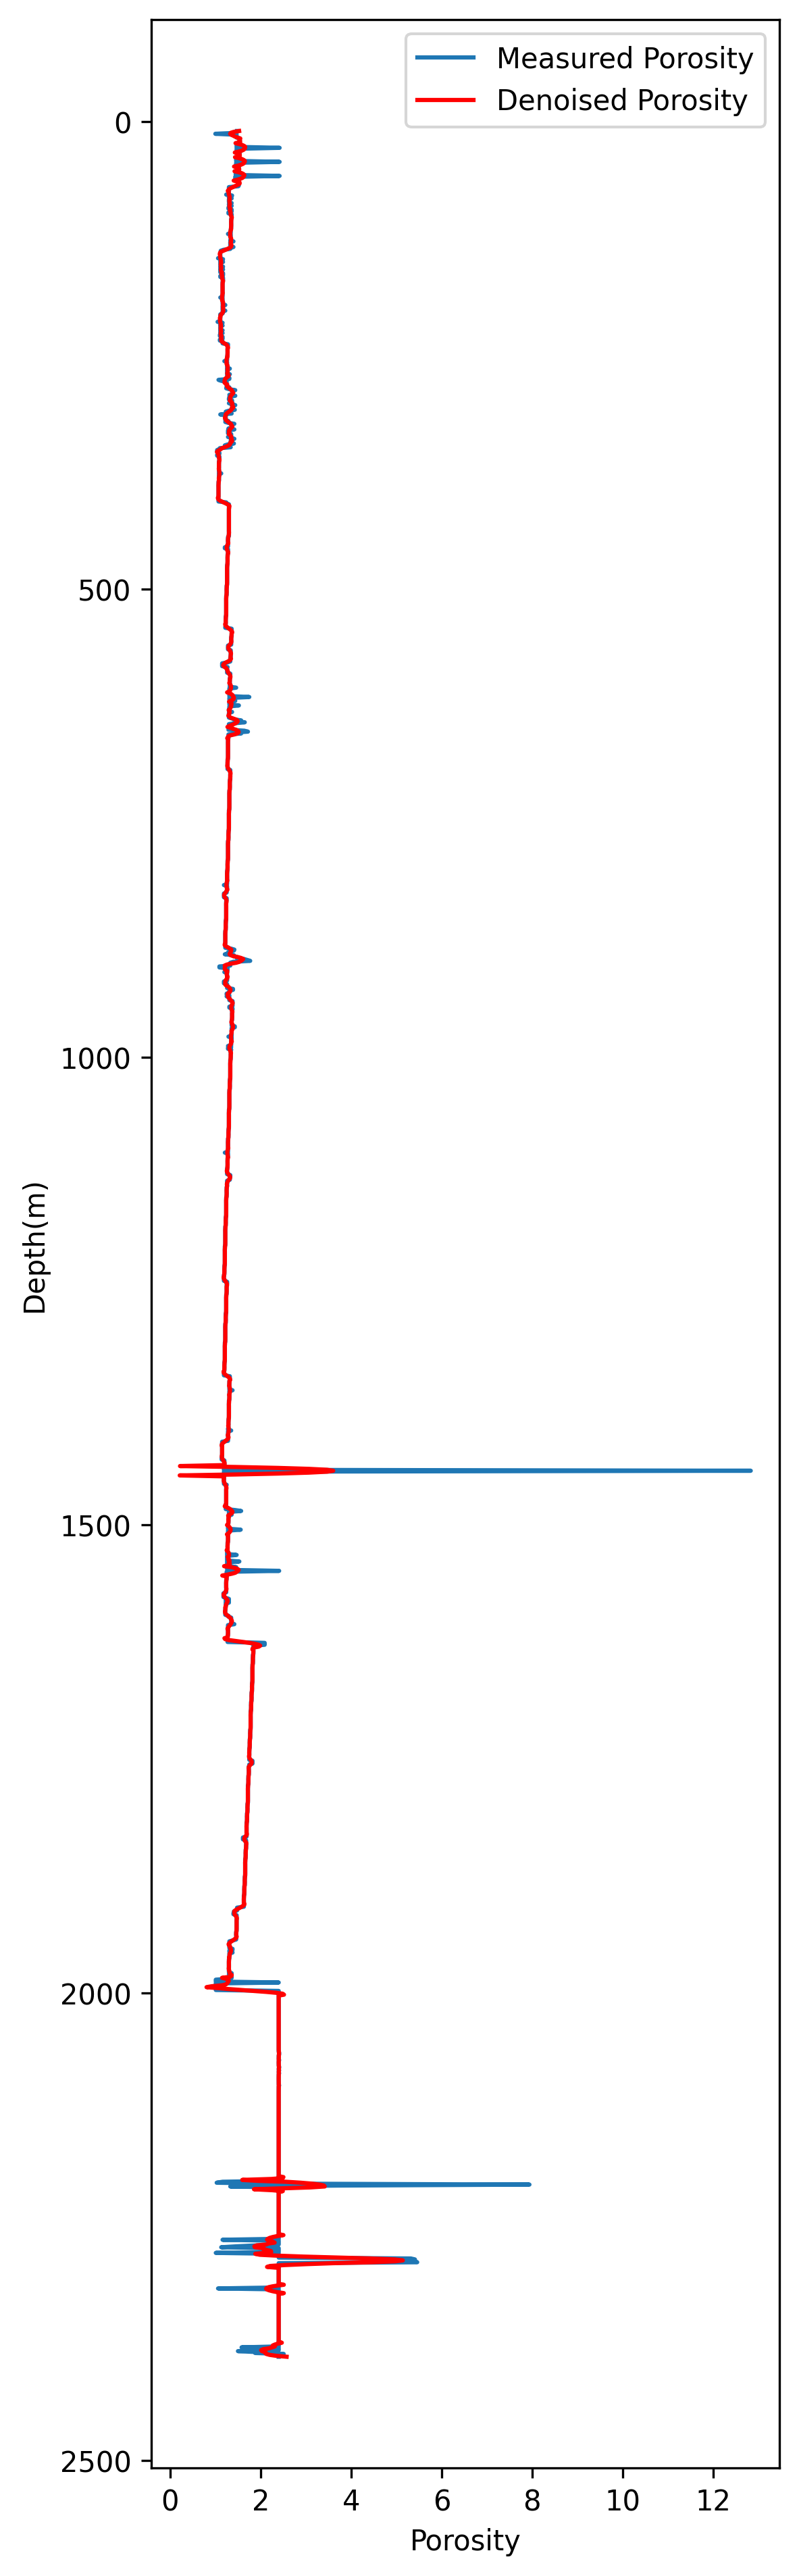

In [16]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['Porosity'],train_rop['Depth'],label='Measured Porosity')
plt.plot(train_2['Porosity'],train_2['Depth'],color='r',label='Denoised Porosity')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('Porosity')
plt.ylabel('Depth(m)')
plt.legend()

In [17]:
from sklearn.metrics import mean_squared_error#MSE
from sklearn.ensemble import ExtraTreesRegressor
# for i in [10,100,200,300]:
ET =   ExtraTreesRegressor(n_estimators=300,random_state=42,max_depth=18,min_samples_split=2)
#模型训练
ET.fit(X_train, y_train)    
#预测
y_test_pred_ET = ET.predict(X_test)
y_train_pred_ET = ET.predict(X_train)
# 评估，使用r2_score评价模型在测试集和训练集上的性能
#     print('i',i)
print ('The r2 score of ET on test is', r2_score(y_test, y_test_pred_ET))
print ('The r2 score of ET on train is', r2_score(y_train, y_train_pred_ET))
print('The RMSE of ET on train is',mean_squared_error(y_train, y_train_pred_ET)**0.5)#RMSE
print('The RMSE of ET on test is',mean_squared_error(y_test, y_test_pred_ET)**0.5)#RMSE
#     print('############')

The r2 score of ET on test is 0.9277434237359975
The r2 score of ET on train is 0.9997487211577063
The RMSE of ET on train is 0.0015820151789810424
The RMSE of ET on test is 0.030146759459199632


In [18]:
y_minmax=MinMaxScaler().fit(train_2['ROP'].values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))
y_test_max=y_test_i.max()
y_train_i=y_minmax.inverse_transform(y_train.values.reshape(-1,1))
y_train_pred_ET_i=y_minmax.inverse_transform(y_train_pred_ET.reshape(-1,1))

In [19]:
y_train_pred_ET_i=y_minmax.inverse_transform(y_train_pred_ET.reshape(-1,1))
y_test_pred_ET_i=y_minmax.inverse_transform(y_test_pred_ET.reshape(-1,1))
print('The RMSE of ET on train is',mean_squared_error(y_train_i, y_train_pred_ET_i)**0.5)
print('The RMSE of ET on test is',mean_squared_error(y_test_i, y_test_pred_ET_i)**0.5)

The RMSE of ET on train is 0.032950204772455235
The RMSE of ET on test is 0.627896565471881


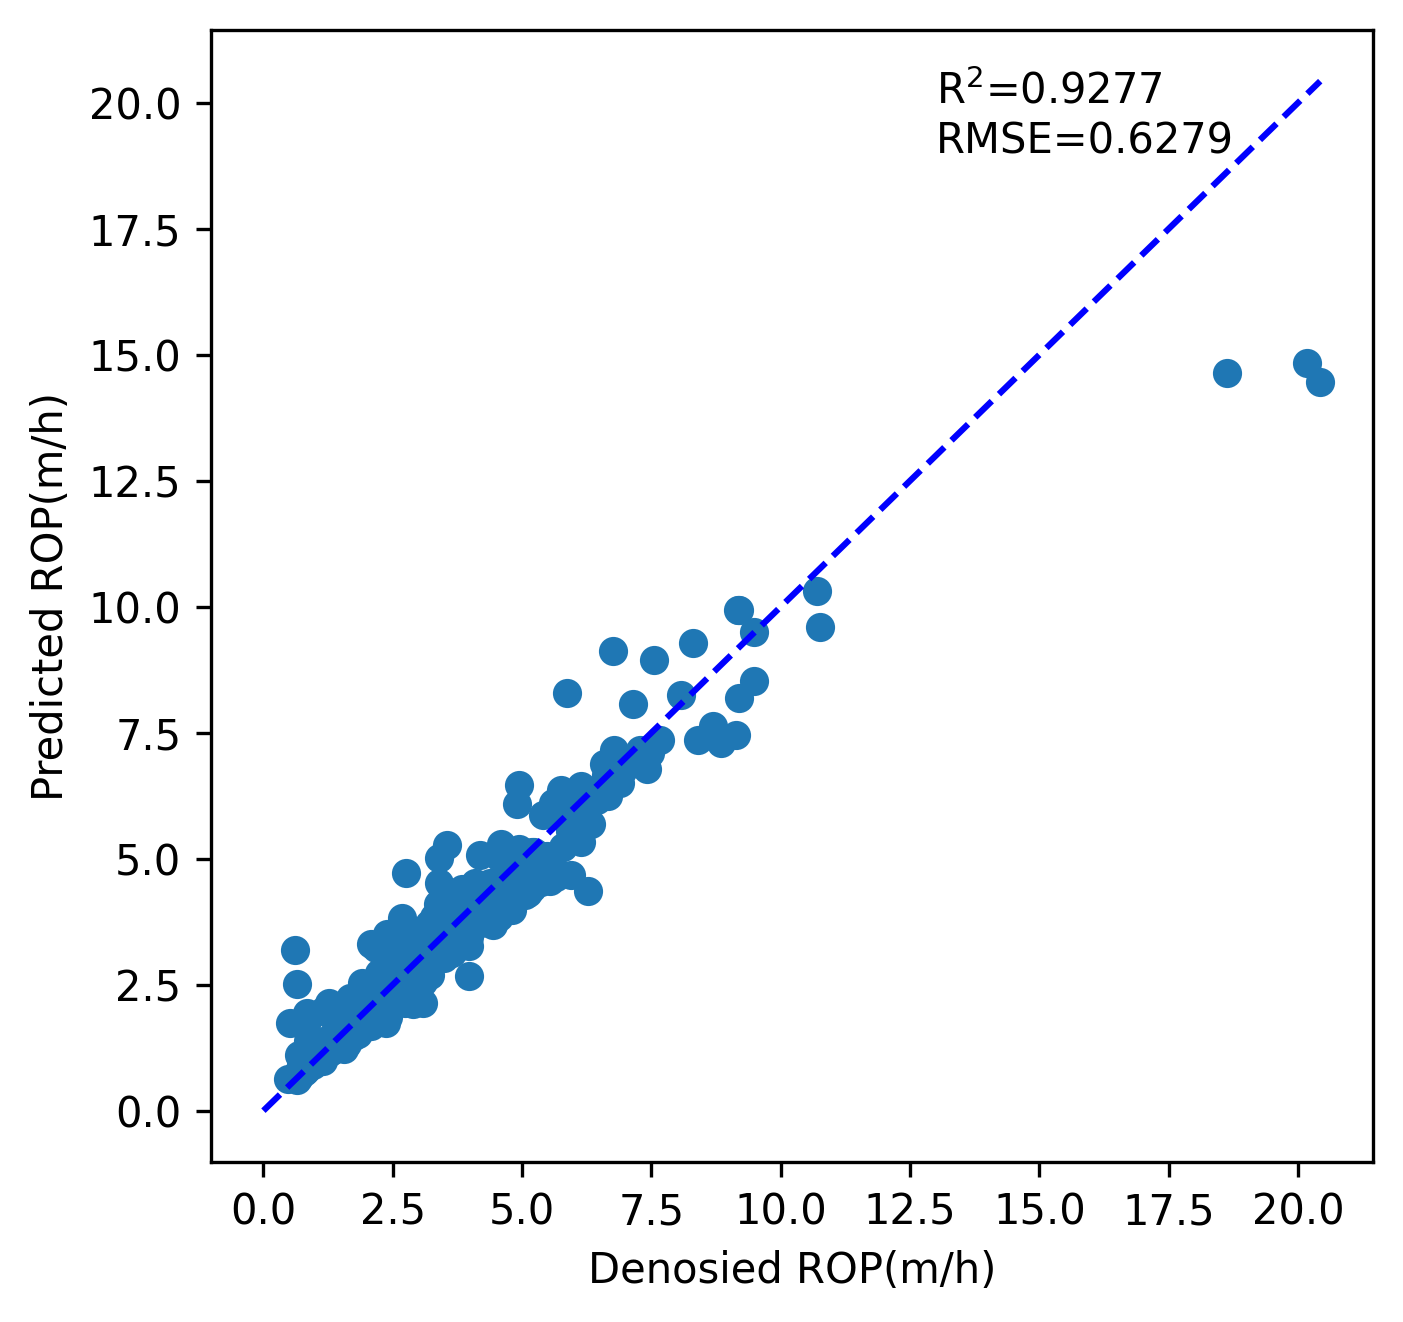

In [20]:
y_test_pred_ET_i=y_minmax.inverse_transform(y_test_pred_ET.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_ET_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_ET))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_ET_i)**0.5)
plt.savefig('et.png', dpi=300,bbox_inches='tight')
# mox.file.copy('et.png', os.path.join(Context.get_output_path(), 'et.png'))

In [21]:
from sklearn.svm import SVR
SVR = SVR(kernel = 'rbf',C=1000,gamma=1)
# SVR = SVR(kernel = 'linear',C=1000,gamma=1)
# SVR=SVR()
SVR.fit(X_train, y_train)
#测试
y_test_pred_SVR = SVR.predict(X_test)
y_train_pred_SVR = SVR.predict(X_train)
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print ('The r2_score of SVR on test is', r2_score(y_test, y_test_pred_SVR))
print ('The r2_score of SVR on train is', r2_score(y_train, y_train_pred_SVR))
print('The RMSE of SVR on train is',mean_squared_error(y_train, y_train_pred_SVR)**0.5)
print('The RMSE of SVR on test is',mean_squared_error(y_test, y_test_pred_SVR)**0.5)

The r2_score of SVR on test is 0.5573937969191716
The r2_score of SVR on train is 0.6069726344110177
The RMSE of SVR on train is 0.06256681968442851
The RMSE of SVR on test is 0.07461234575241847


In [22]:
y_minmax=MinMaxScaler().fit(train_2['ROP'].values.reshape(-1,1))
y_train_pred_SVR_i=y_minmax.inverse_transform(y_train_pred_SVR.reshape(-1,1))
y_test_pred_SVR_i=y_minmax.inverse_transform(y_test_pred_SVR.reshape(-1,1))
print('The RMSE of lg on train is',mean_squared_error(y_train_i, y_train_pred_SVR_i)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test_i, y_test_pred_SVR_i)**0.5)

The RMSE of lg on train is 1.303141428700481
The RMSE of lg on test is 1.5540255894882788


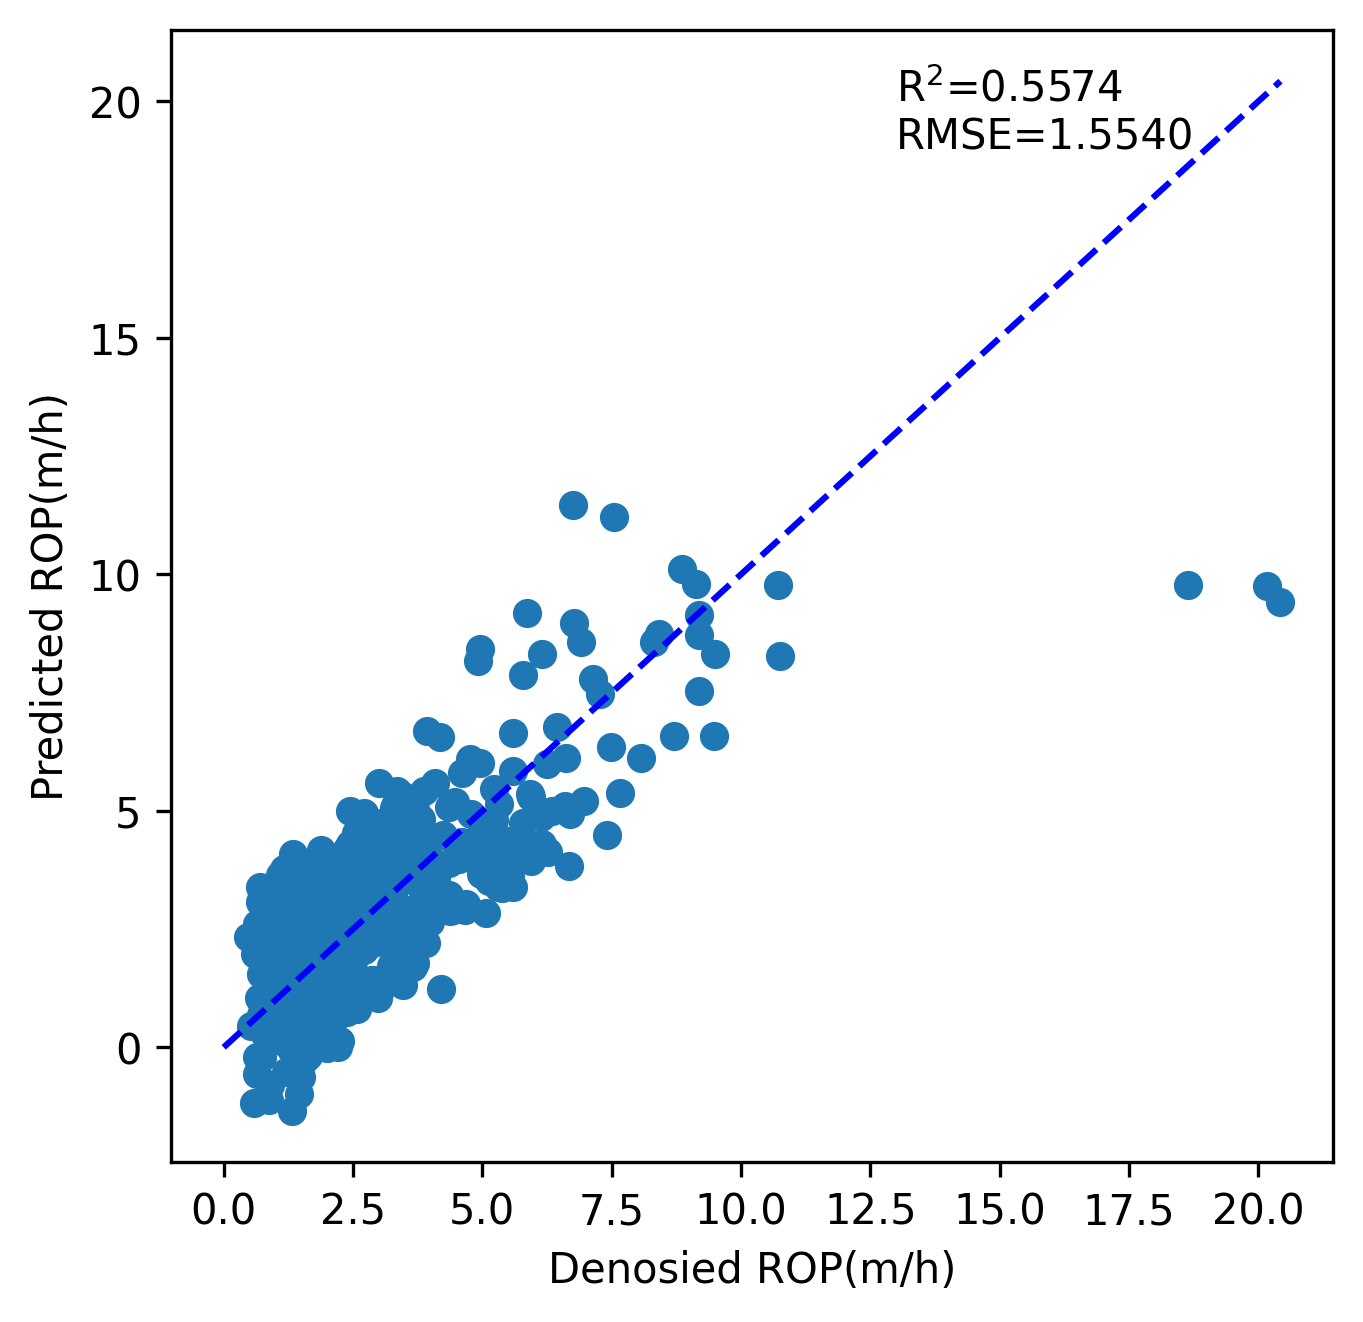

In [23]:
y_test_pred_SVR_i=y_minmax.inverse_transform(y_test_pred_SVR.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_SVR_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_SVR))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_SVR_i)**0.5)
plt.savefig('svr.png', dpi=300,bbox_inches='tight')
# mox.file.copy('svr.png', os.path.join(Context.get_output_path(), 'svr.png'))

In [24]:
from lightgbm.sklearn import LGBMRegressor
params={
     'n_estimators':200,
#        'num_leaves': 35,
#     'objective': 'regression',
#     'min_data_in_leaf': 20,
    'learning_rate': 0.1,
    'max_depth': 15
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 1,
#     'metric': 'l2',
#     'num_threads': 4  
       }
LightGBM=LGBMRegressor(**params)
LightGBM.fit(X_train, y_train)
#测试
y_test_pred_LightGBM = LightGBM.predict(X_test)
y_train_pred_LightGBM =LightGBM.predict(X_train)

print ('The r2 score of LightGBM on test is', r2_score(y_test, y_test_pred_LightGBM))
print ('The r2 score of LightGBM on train is', r2_score(y_train, y_train_pred_LightGBM))
print('The RMSE of LightGBM on train is',mean_squared_error(y_train, y_train_pred_LightGBM)**0.5)
print('The RMSE of LightGBM on test is',mean_squared_error(y_test, y_test_pred_LightGBM)**0.5)

The r2 score of LightGBM on test is 0.8777225267561044
The r2 score of LightGBM on train is 0.9787162730652536
The RMSE of LightGBM on train is 0.014559837370944188
The RMSE of LightGBM on test is 0.0392170727543874


In [25]:
y_train_pred_LightGBM_i=y_minmax.inverse_transform(y_train_pred_LightGBM.reshape(-1,1))
y_test_pred_LightGBM_i=y_minmax.inverse_transform(y_test_pred_LightGBM.reshape(-1,1))
print('The RMSE of LightGBM on train is',mean_squared_error(y_train_i, y_train_pred_LightGBM_i)**0.5)
print('The RMSE of LightGBM on test is',mean_squared_error(y_test_i, y_test_pred_LightGBM_i)**0.5)

The RMSE of LightGBM on train is 0.30325222488399795
The RMSE of LightGBM on test is 0.8168130084982103


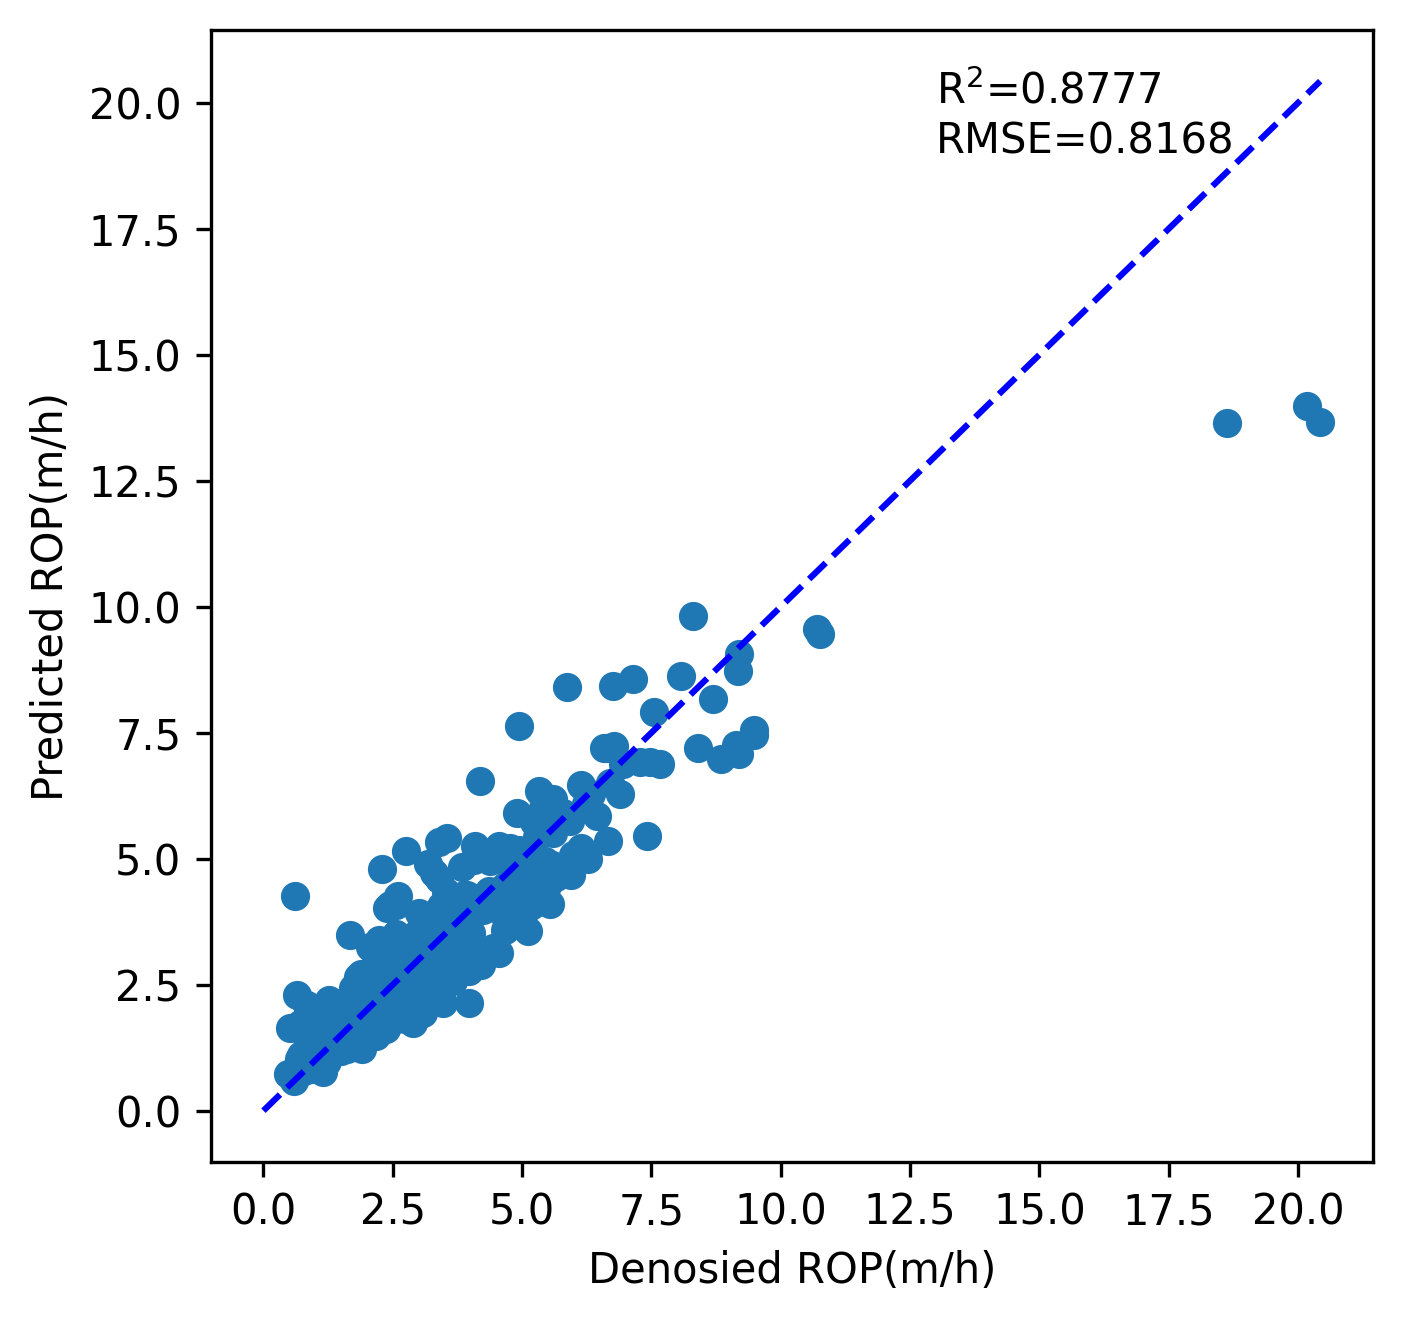

In [26]:
y_test_pred_LightGBM_i=y_minmax.inverse_transform(y_test_pred_LightGBM.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_LightGBM_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_LightGBM))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_LightGBM_i)**0.5)
plt.savefig('lg.png', dpi=300,bbox_inches='tight')
# mox.file.copy('lg.png', os.path.join(Context.get_output_path(), 'lg.png'))

In [27]:
from sklearn.ensemble import RandomForestRegressor

# RF = RandomForestRegressor
RF = RandomForestRegressor(
    n_estimators=200, 
#     criterion="entropy",
    max_depth=20,    
    min_samples_split=2, 
#     min_samples_leaf=1,    
#     min_weight_fraction_leaf=0.0,    
#     max_features='auto',    
#     max_leaf_nodes=50, bootstrap=True,    
#     oob_score=False,
    random_state=42, 
#     verbose=0,    
   )
RF.fit(X_train, y_train)
#测试
y_test_pred_RF = RF.predict(X_test)
y_train_pred_RF= RF.predict(X_train)

# # 评估，使用 评价模型在测试集和训练集上的性能
print ('The r2 score of RF on test is', r2_score(y_test, y_test_pred_RF))
print ('The r2 score of RF on train is', r2_score(y_train, y_train_pred_RF))
print('The RMSE of RF on train is',mean_squared_error(y_train, y_train_pred_RF)**0.5)
print('The RMSE of RF on test is',mean_squared_error(y_test, y_test_pred_RF)**0.5)

The r2 score of RF on test is 0.8730991743764032
The r2 score of RF on train is 0.9854131328112488
The RMSE of RF on train is 0.012053514627616186
The RMSE of RF on test is 0.039951599352593285


In [28]:
y_train_pred_RF_i=y_minmax.inverse_transform(y_train_pred_RF.reshape(-1,1))
y_test_pred_RF_i=y_minmax.inverse_transform(y_test_pred_RF.reshape(-1,1))
print('The RMSE of RF on train is',mean_squared_error(y_train_i, y_train_pred_RF_i)**0.5)
print('The RMSE of RF on test is',mean_squared_error(y_test_i, y_test_pred_RF_i)**0.5)

The RMSE of RF on train is 0.2510505464704503
The RMSE of RF on test is 0.8321117250612764


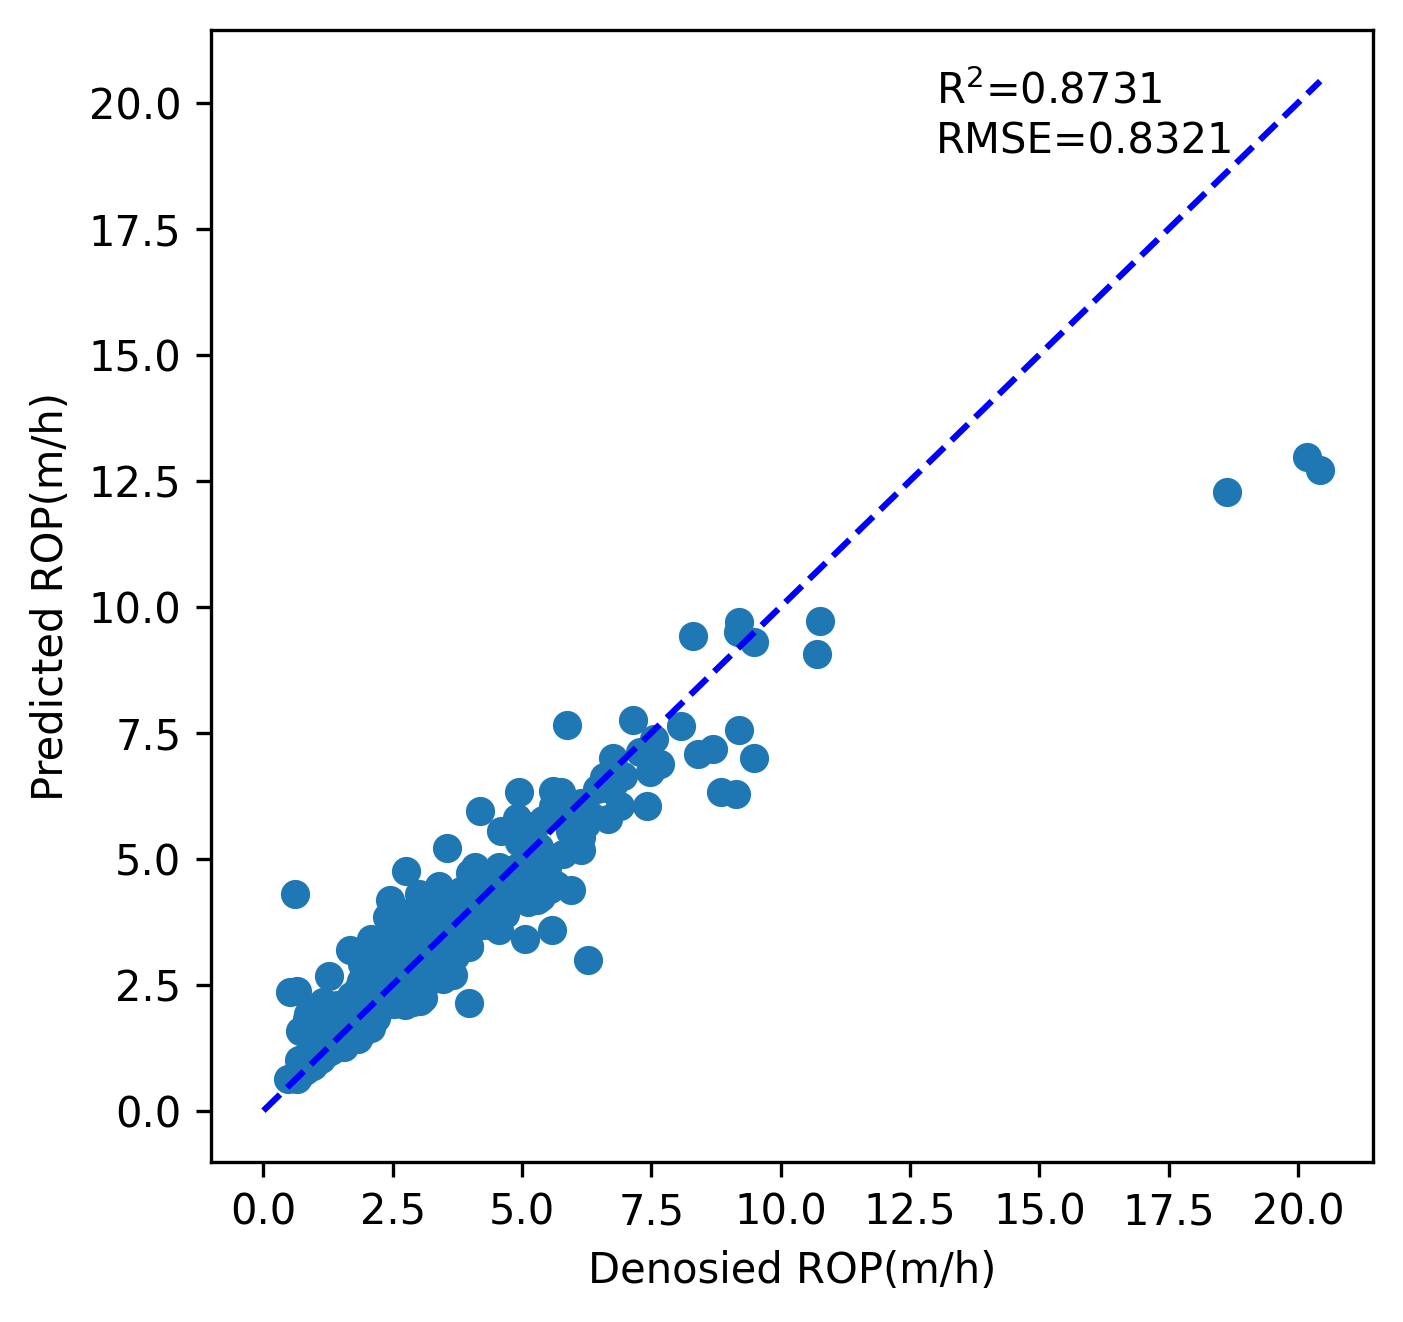

In [29]:
y_test_pred_RF_i=y_minmax.inverse_transform(y_test_pred_RF.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_RF_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_RF))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_RF_i)**0.5)
plt.savefig('rf.png', dpi=300,bbox_inches='tight')
# mox.file.copy('rf.png', os.path.join(Context.get_output_path(), 'rf.png'))

In [30]:
from xgboost import XGBRegressor
XGB =XGBRegressor(n_estimators=300,random_state=42,gamma=0.0001)

XGB.fit(X_train, y_train)
#测试
y_test_pred_XGB = XGB.predict(X_test)
y_train_pred_XGB= XGB.predict(X_train)

# # 评估，使用 评价模型在测试集和训练集上的性能

print ('The r2 score of XGB on test is', r2_score(y_test, y_test_pred_XGB))
print ('The r2 score of XGB on train is', r2_score(y_train, y_train_pred_XGB))
print('The RMSE of XGB on train is',mean_squared_error(y_train, y_train_pred_XGB)**0.5)
print('The RMSE of XGB on test is',mean_squared_error(y_test, y_test_pred_XGB)**0.5)

[03:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The r2 score of XGB on test is 0.8058848111389099
The r2 score of XGB on train is 0.9221772483545395
The RMSE of XGB on train is 0.027841073451881092
The RMSE of XGB on test is 0.04941191724156793


In [31]:
y_train_pred_XGB_i=y_minmax.inverse_transform(y_train_pred_XGB.reshape(-1,1))
y_test_pred_XGB_i=y_minmax.inverse_transform(y_test_pred_XGB.reshape(-1,1))
print('The RMSE of XGB on train is',mean_squared_error(y_train_i, y_train_pred_XGB_i)**0.5)
print('The RMSE of XGB on test is',mean_squared_error(y_test_i, y_test_pred_XGB_i)**0.5)

The RMSE of XGB on train is 0.5798737599970111
The RMSE of XGB on test is 1.0291511844693657


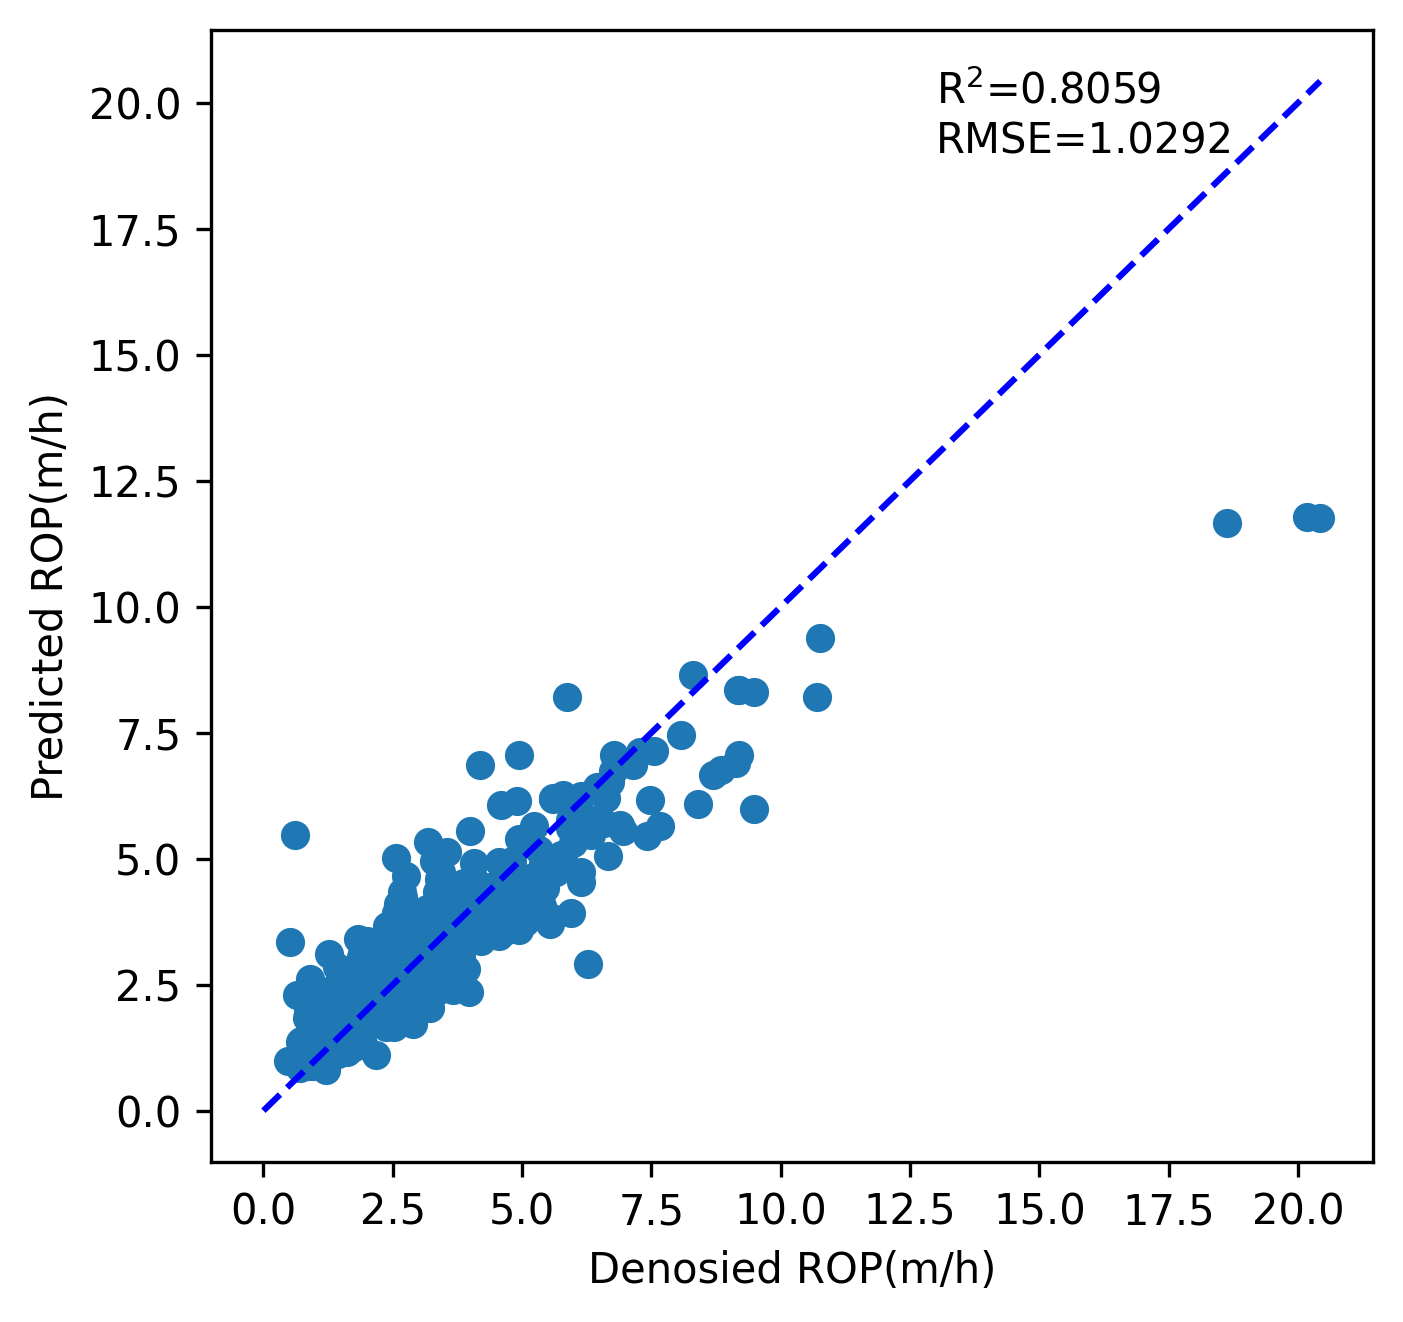

In [32]:
y_test_pred_XGB_i=y_minmax.inverse_transform(y_test_pred_XGB.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_XGB_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_XGB))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_XGB_i)**0.5)
plt.savefig('xgb.png', dpi=300,bbox_inches='tight')
# mox.file.copy('xgb.png', os.path.join(Context.get_output_path(), 'xgb.png'))

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
GB =GradientBoostingRegressor(n_estimators=800,max_depth=3,learning_rate=0.1,random_state=42)

GB.fit(X_train, y_train)
#测试
y_test_pred_GB = GB.predict(X_test)
y_train_pred_GB= GB.predict(X_train)

# # 评估，使用 评价模型在测试集和训练集上的性能

print ('The r2 score of GB on test is', r2_score(y_test, y_test_pred_GB))
print ('The r2 score of GB on train is', r2_score(y_train, y_train_pred_GB))
print('The RMSE of GB on train is',mean_squared_error(y_train, y_train_pred_GB)**0.5)
print('The RMSE of GB on test is',mean_squared_error(y_test, y_test_pred_GB)**0.5)

The r2 score of GB on test is 0.8663674272085341
The r2 score of GB on train is 0.9854276527458664
The RMSE of GB on train is 0.012047514030742841
The RMSE of GB on test is 0.04099756951081737


In [34]:
y_train_pred_GB_i=y_minmax.inverse_transform(y_train_pred_GB.reshape(-1,1))
y_test_pred_GB_i=y_minmax.inverse_transform(y_test_pred_GB.reshape(-1,1))
print('The RMSE of GB on train is',mean_squared_error(y_train_i, y_train_pred_GB_i)**0.5)
print('The RMSE of GB on test is',mean_squared_error(y_test_i, y_test_pred_GB_i)**0.5)

The RMSE of GB on train is 0.25092556606674704
The RMSE of GB on test is 0.8538971866404499


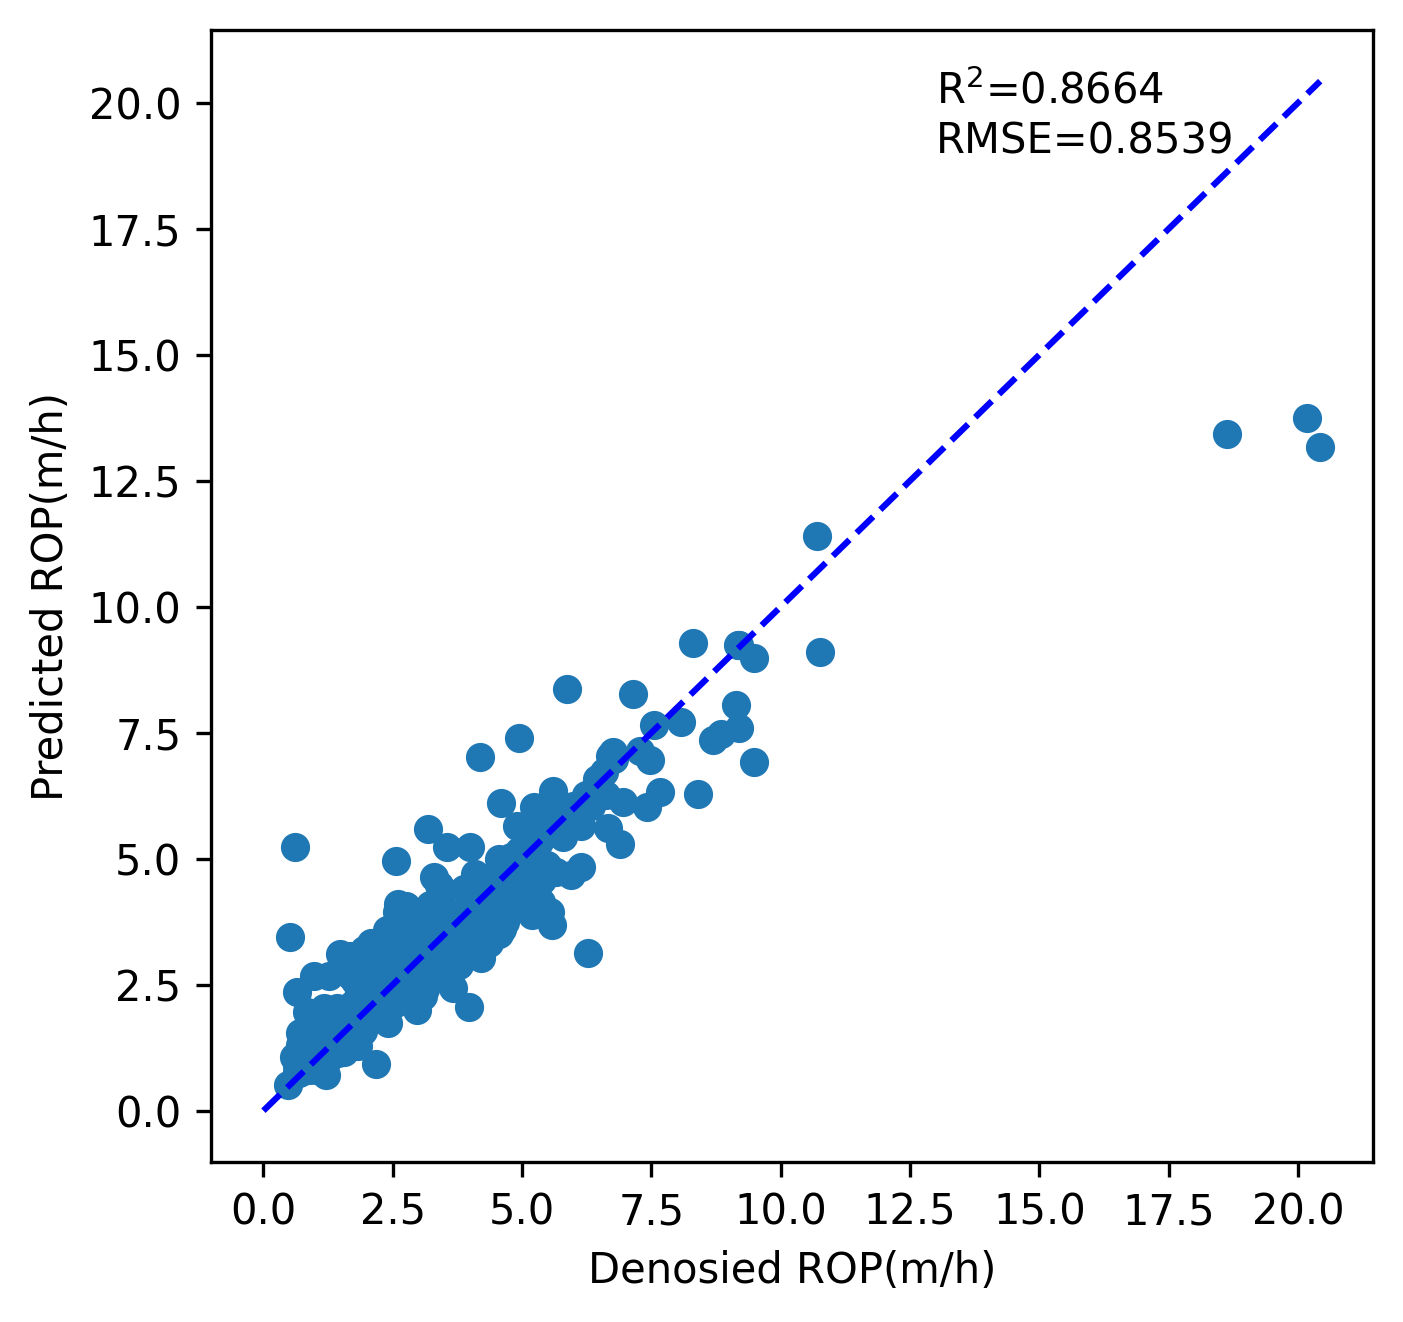

In [35]:
y_test_pred_GB_i=y_minmax.inverse_transform(y_test_pred_GB.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_GB_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_GB))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_GB_i)**0.5)
plt.savefig('gb.png', dpi=300,bbox_inches='tight')
# mox.file.copy('gb.png', os.path.join(Context.get_output_path(), 'gb.png'))

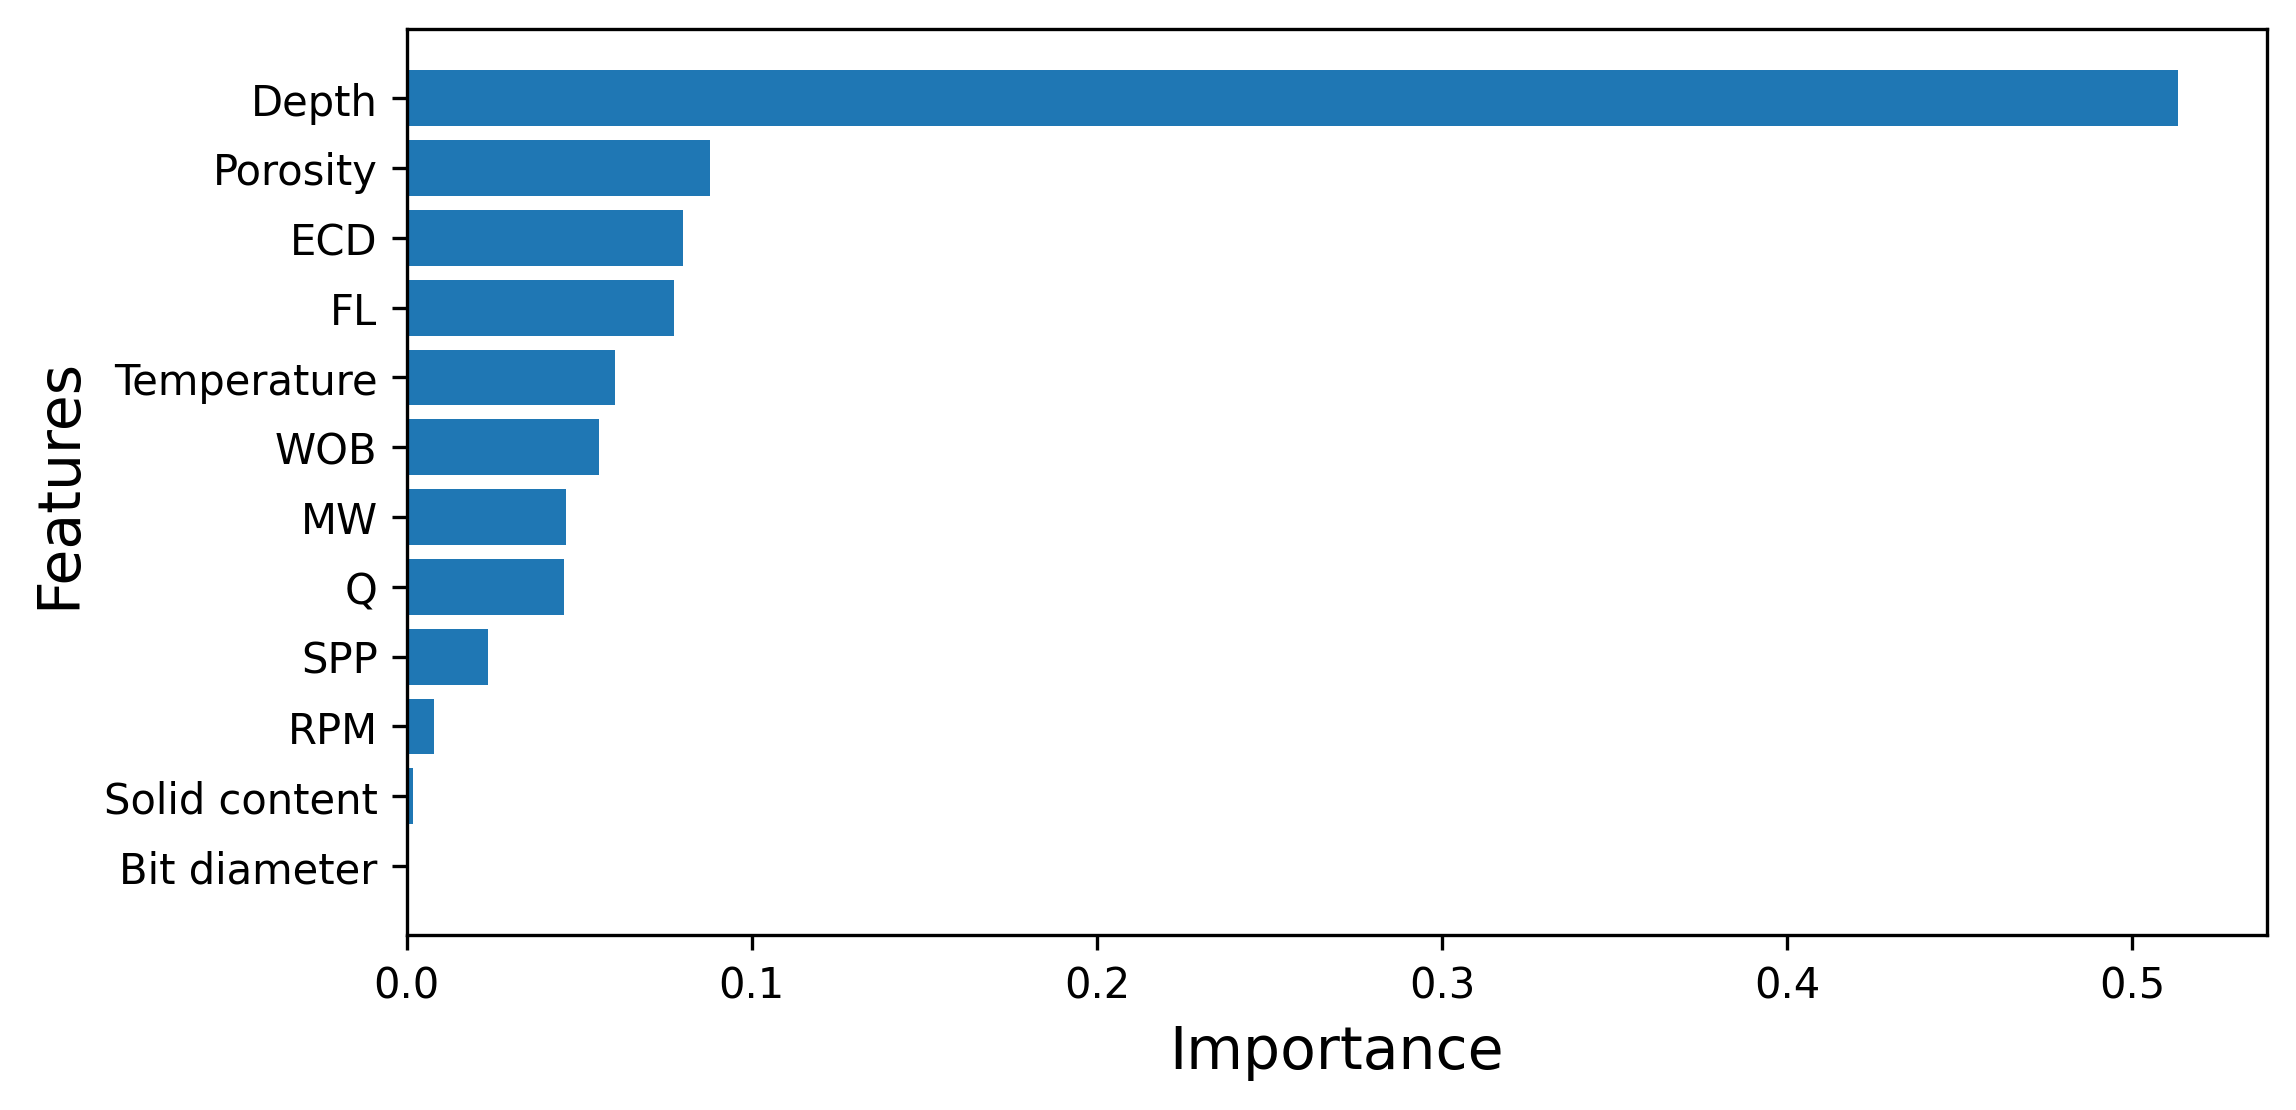

In [36]:
features_list=X.columns
df_gb = pd.DataFrame({"columns":features_list, "importance":list(GB.feature_importances_.T)})
df_gb = df_gb.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_gb['columns'] ,df_gb['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_gb.png', dpi=300,bbox_inches='tight')
# mox.file.copy('df_gb.png', os.path.join(Context.get_output_path(), 'df_gb.png'))

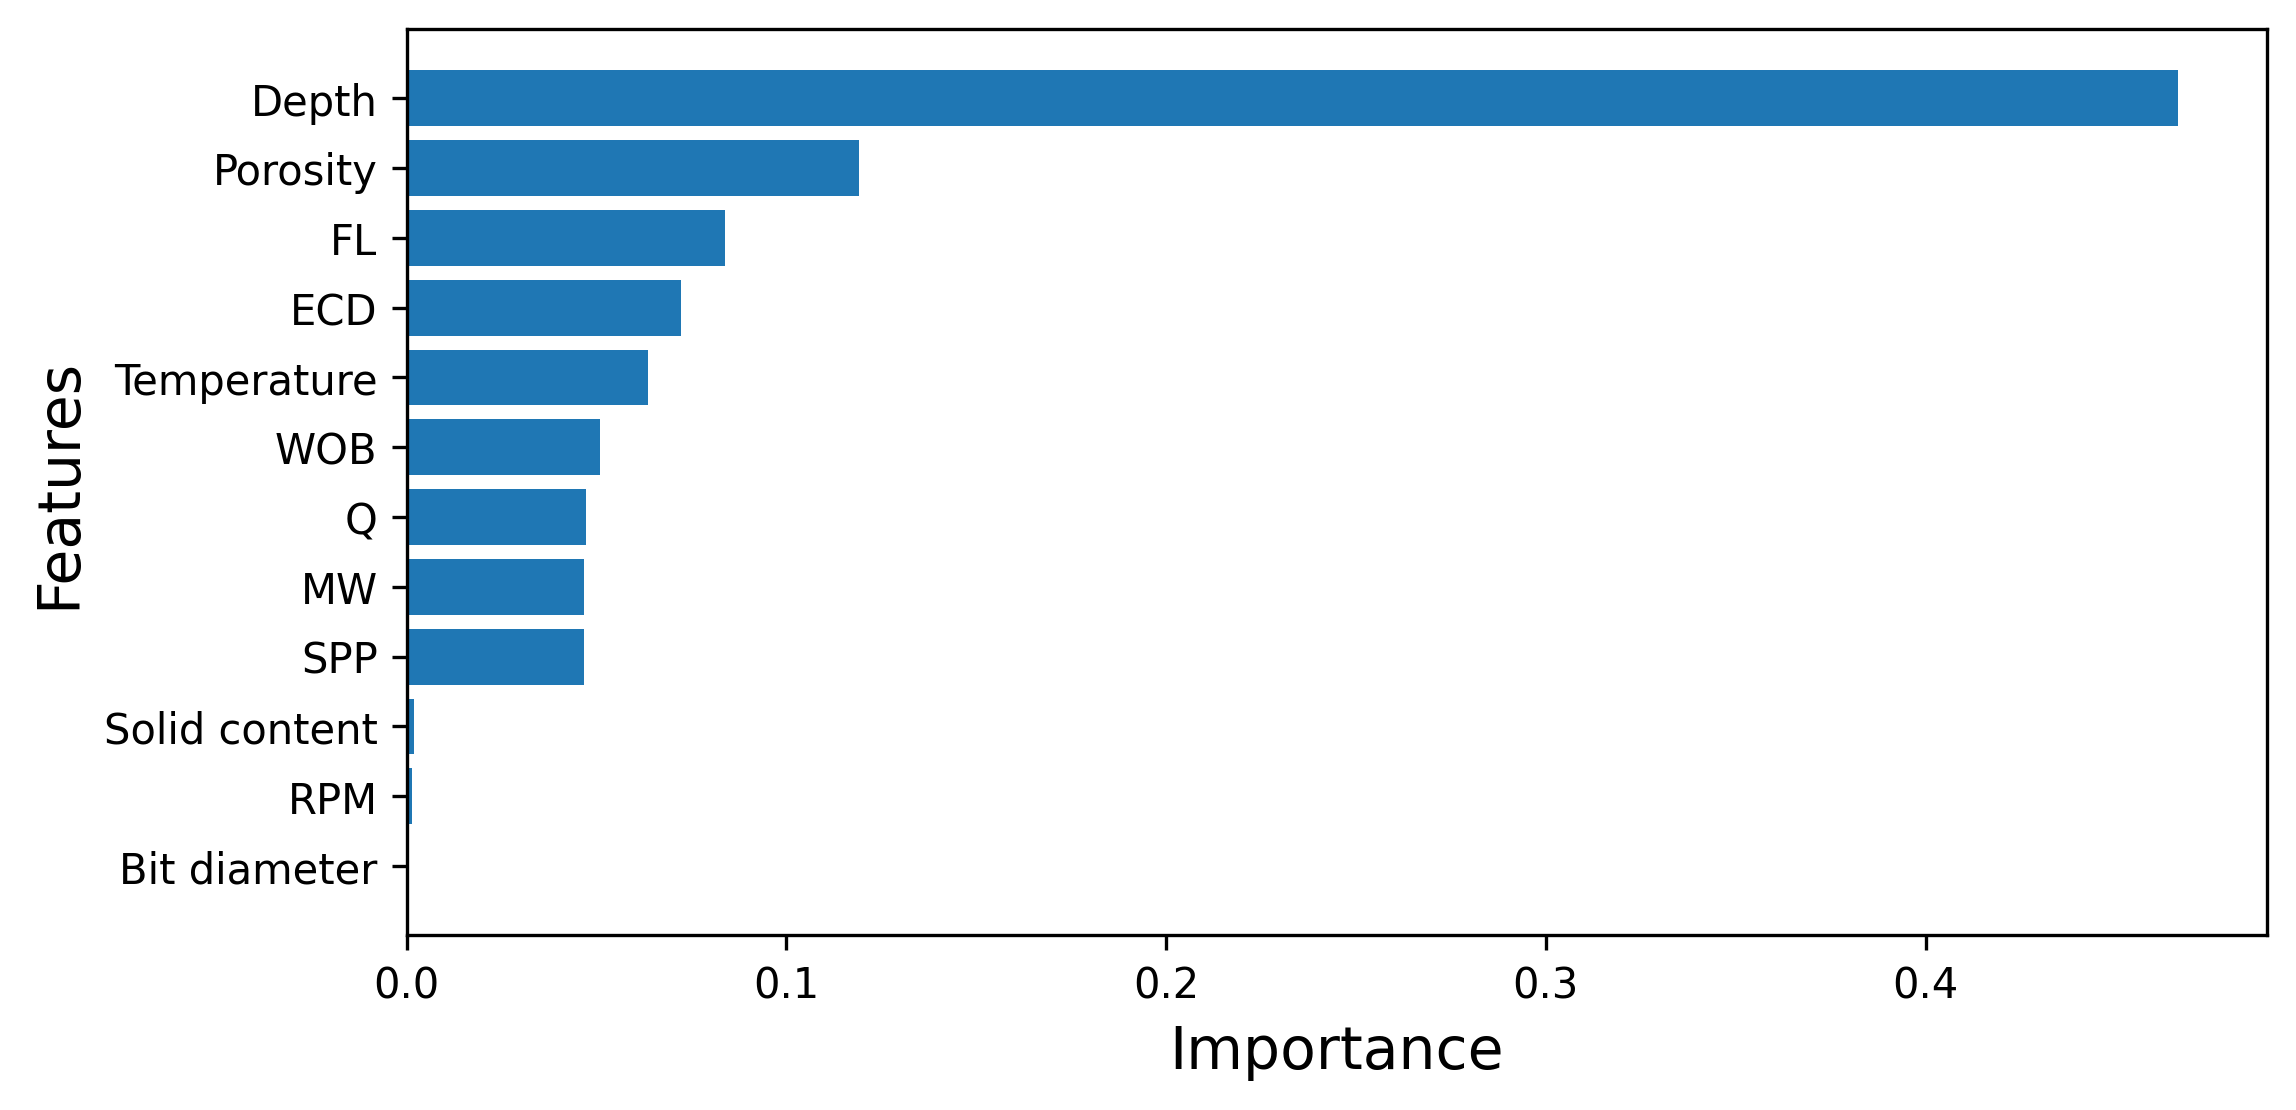

In [37]:
df_rf = pd.DataFrame({"columns":features_list, "importance":list(RF.feature_importances_.T)})
df_rf = df_rf.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_rf['columns'] ,df_rf['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_rf.png', dpi=300,bbox_inches='tight')
# mox.file.copy('df_rf.png', os.path.join(Context.get_output_path(), 'df_rf.png'))

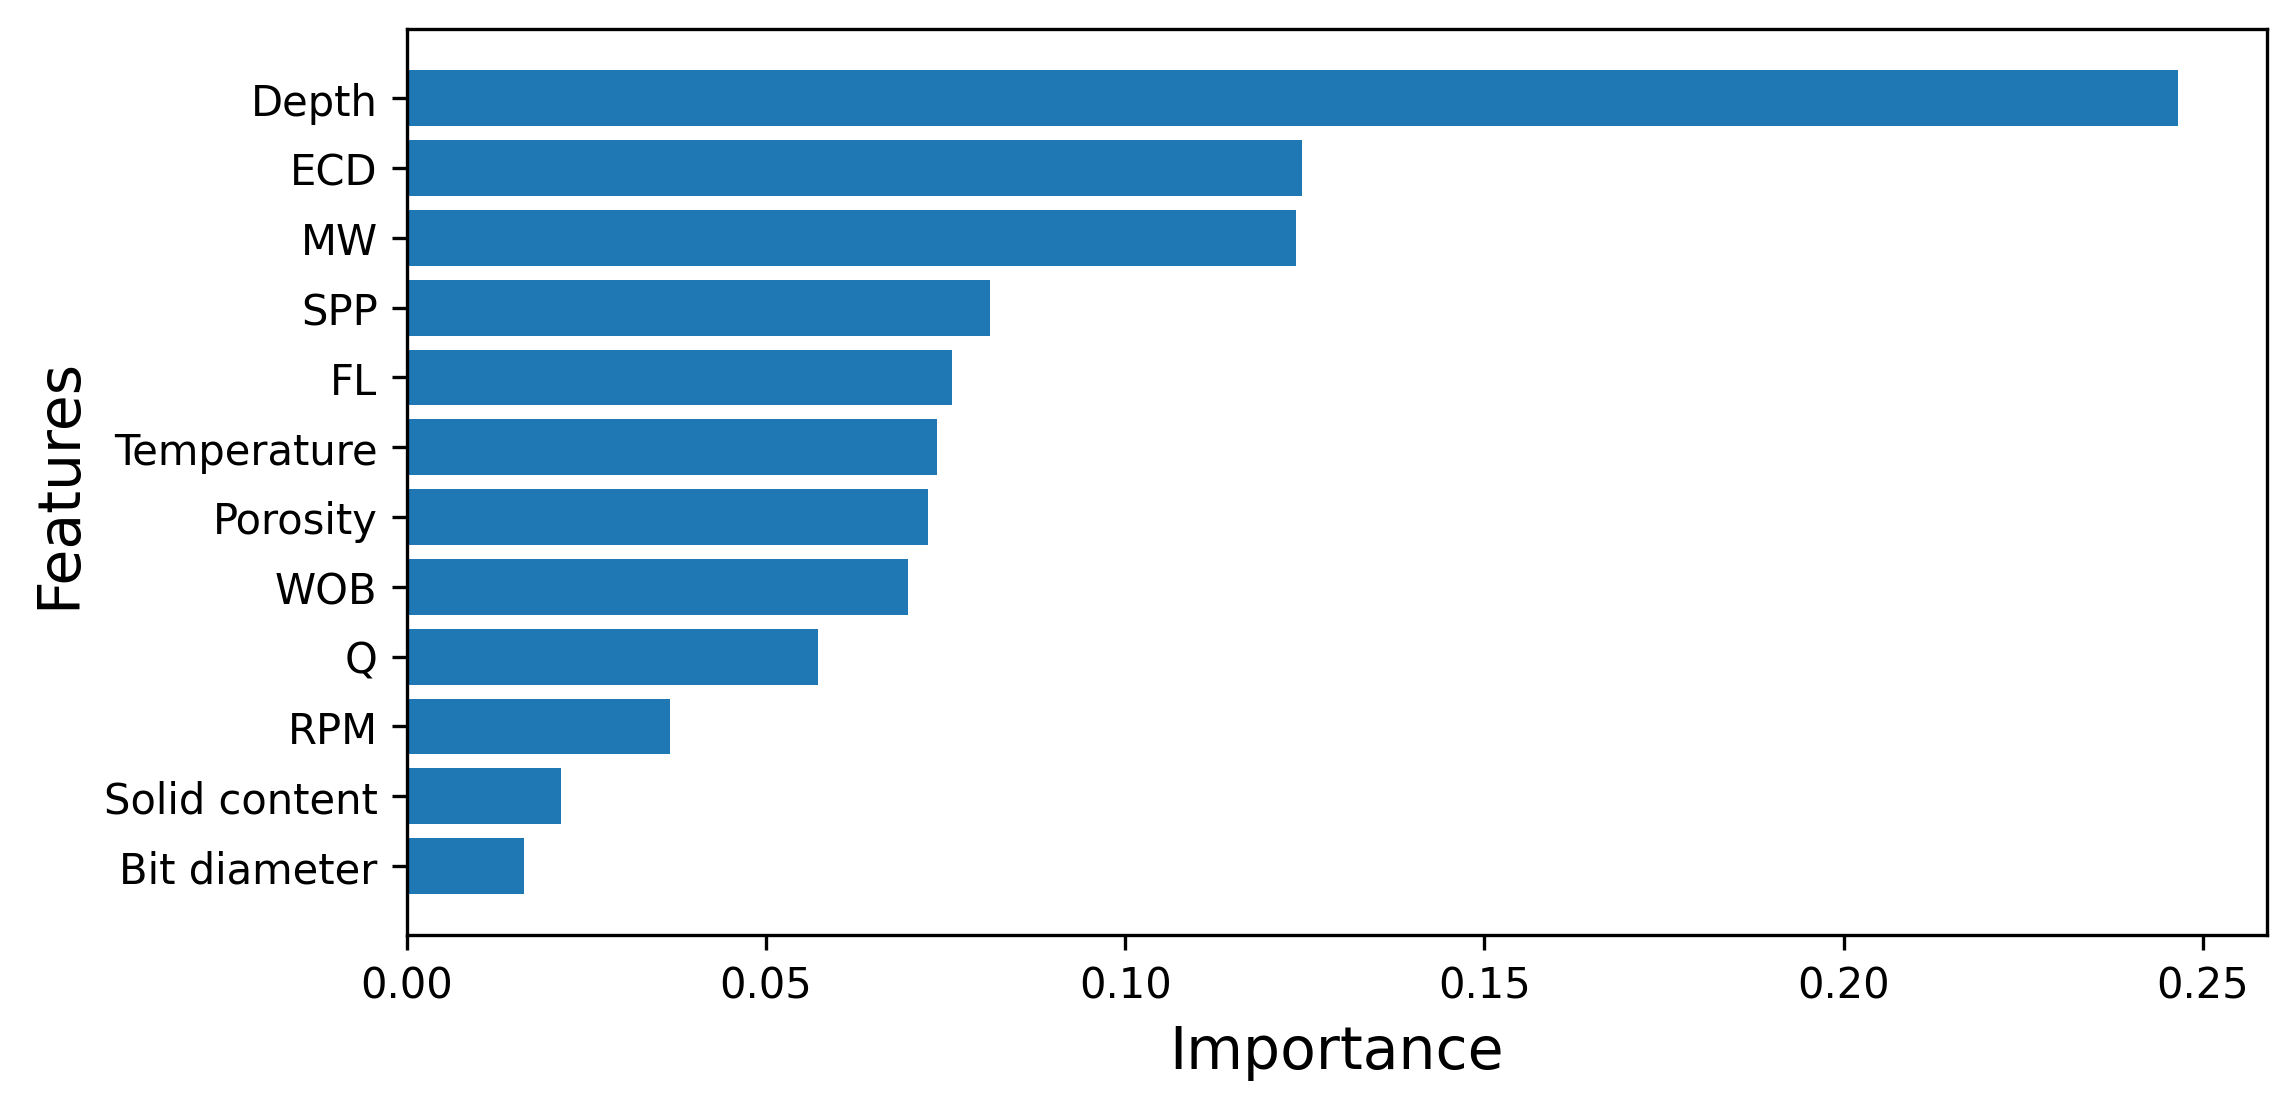

In [38]:
df_et = pd.DataFrame({"columns":features_list, "importance":list(ET.feature_importances_.T)})
df_et = df_et.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_et['columns'] ,df_et['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_et.png', dpi=300,bbox_inches='tight')
# mox.file.copy('df_et.png', os.path.join(Context.get_output_path(), 'df_et.png'))

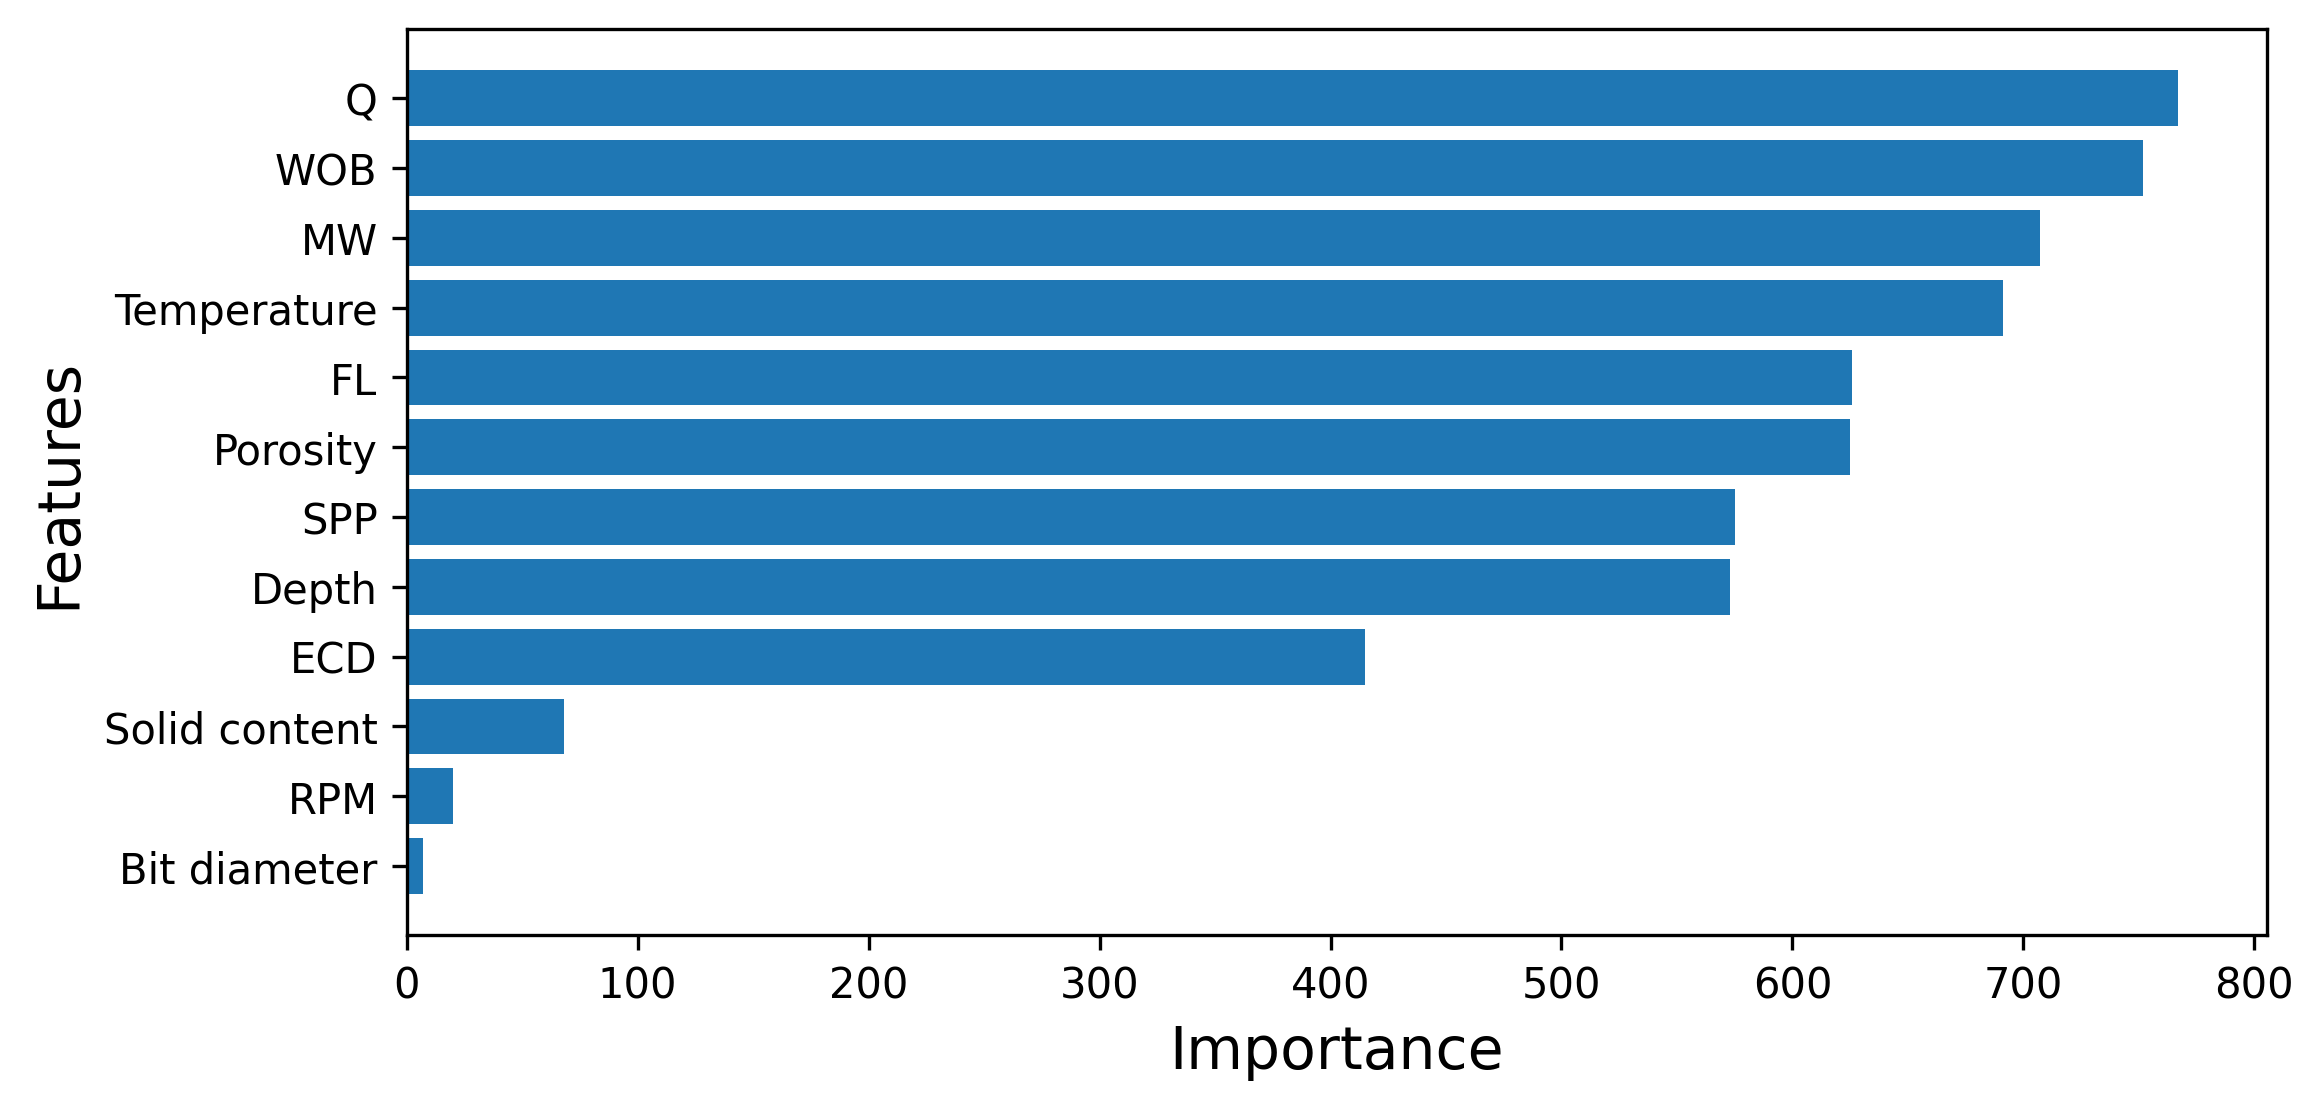

In [39]:
df_lg = pd.DataFrame({"columns":features_list, "importance":list(LightGBM.feature_importances_.T)})
df_lg = df_lg.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_lg['columns'] ,df_lg['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_lg.png', dpi=300,bbox_inches='tight')
# mox.file.copy('df_lg.png', os.path.join(Context.get_output_path(), 'df_lg.png'))

In [40]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
estimators = [

    ('SVR', SVR(kernel = 'rbf',C=100)),
#     ('rf1', RandomForestRegressor(n_estimators=20,random_state=42)),
#     ('ETR1', ExtraTreesRegressor(n_estimators=10,random_state=42)),
    ('RF', RandomForestRegressor(n_estimators=200,max_depth=20,random_state=42)),
    ('ET', ExtraTreesRegressor(n_estimators=300,max_depth=18,min_samples_split=2,random_state=42)),
    ('LightGBM', LGBMRegressor(n_estimators=200,max_depth=15,learning_rate= 0.1,random_state=42)),
#     ('ab', AdaBoostRegressor(random_state=42)),
    ('GB', GradientBoostingRegressor(n_estimators=800,max_depth=3,learning_rate= 0.1,random_state=33))
    
]
stacked = StackingRegressor(
    estimators=estimators,
#     final_estimator=MLPRegressor(solver='adam', hidden_layer_sizes=(50,20), learning_rate= 'adaptive',random_state=1),
#     final_estimator=RidgeCV(),
    cv=5,
#     final_estimator=LassoCV()
#     final_estimator=LinearSVR()
    final_estimator=XGBRegressor(n_estimators=300,random_state=42,gamma=0.001),
#     passthrough=True
)

stack_r2_test=stacked.fit(X_train, y_train).score(X_test, y_test)
stack_r2_train=stacked.score(X_train, y_train)
print('stack_r2_test',stack_r2_test)
print('stack_r2_train',stack_r2_train)

[03:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
stack_r2_test 0.9550896163214231
stack_r2_train 0.9892412958192043


In [41]:
y_test_pred_s=stacked.predict(X_test)
y_train_pred_s=stacked.predict(X_train)
print ('The r2 score of stacked on test is', r2_score(y_test, y_test_pred_s))
print ('The r2 score of stacked on train is', r2_score(y_train, y_train_pred_s))
print('The RMSE of stacked on train is',mean_squared_error(y_train, y_train_pred_s)**0.5)
print('The RMSE of stacked on test is',mean_squared_error(y_test, y_test_pred_s)**0.5)

The r2 score of stacked on test is 0.9550896163214231
The r2 score of stacked on train is 0.9892412958192043
The RMSE of stacked on train is 0.01035172361500483
The RMSE of stacked on test is 0.023767052671090586


In [42]:
y_train_pred_s_i=y_minmax.inverse_transform(y_train_pred_s.reshape(-1,1))
y_test_pred_s_i=y_minmax.inverse_transform(y_test_pred_s.reshape(-1,1))
y_train_i=y_minmax.inverse_transform(y_train.values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))
print('The RMSE of stacked on train is',mean_squared_error(y_train_i, y_train_pred_s_i)**0.5)
print('The RMSE of stacked on test is',mean_squared_error(y_test_i, y_test_pred_s_i)**0.5)

The RMSE of stacked on train is 0.21560564018693218
The RMSE of stacked on test is 0.49502007740168047


In [43]:
y_train_i=y_minmax.inverse_transform(y_train.values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))

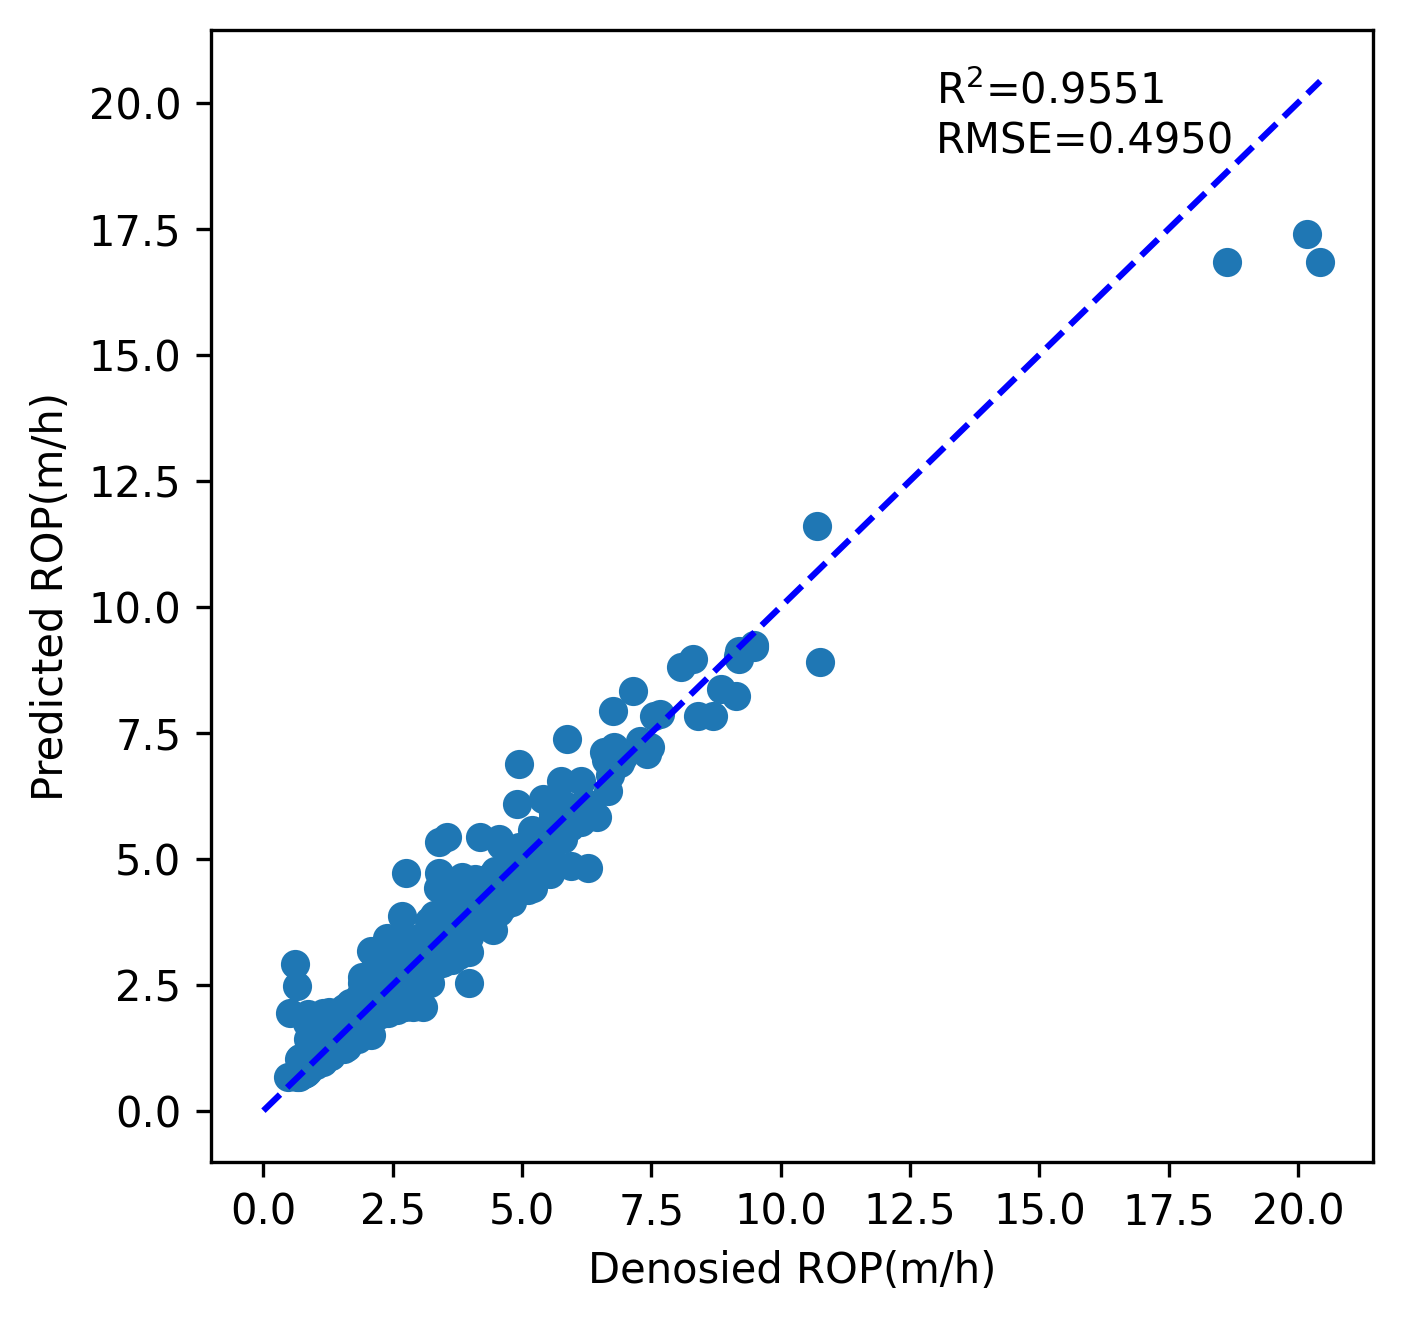

In [44]:
y_minmax=MinMaxScaler().fit(train_2['ROP'].values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))
y_test_max=y_test_i.max()
y_test_pred_s_i=y_minmax.inverse_transform(y_test_pred_s.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_s_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_s))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_s_i)**0.5)
plt.savefig('stack.png', dpi=300,bbox_inches='tight')
# mox.file.copy('stack.png', os.path.join(Context.get_output_path(), 'stack.png'))